# **FINAL DEEP LEARNING**  
## **No. 3**

Sherly Vaneza  
2702222163

# LINK YOUTUBE: https://youtu.be/YWguayqBK04

# Dalam perjalanan riset anda, ternyata ada kebutuhan untuk menghasilkan data sintetis. Untuk data yang sama dengan data No. 2, anda berniat menambah data dengan menggunakan teknik Generative Advesarial Network (GAN)

## Import Library

In [107]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import time

# Impor untuk evaluasi FID
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

## Drive

In [108]:
from google.colab import drive
drive.mount('/content/drive')

print("\nGoogle Drive berhasil terhubung.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Google Drive berhasil terhubung.


## Zip

In [109]:
import zipfile
zip_path = '/content/drive/MyDrive/FinalProjectDeepLearning/B_23.zip'
extract_path = '/content/dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Parameter

In [110]:
# --- Konfigurasi Parameter ---
IMG_HEIGHT = 100
IMG_WIDTH = 100
IMG_CHANNELS = 3
LATENT_DIM = 100 # Dimensi untuk vektor noise input generator
BATCH_SIZE = 32 # Ukuran batch

In [111]:
# Fungsi ini sekarang hanya mengharapkan 'image', sesuai dengan isi dataset kita
def normalize_images(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

print(f"Memuat gambar dari folder yang sudah diekstrak: {extract_path}")

Memuat gambar dari folder yang sudah diekstrak: /content/dataset/


In [112]:
IMAGE_DIR = extract_path

In [113]:
real_dataset = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIR,
    label_mode=None,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

real_dataset = real_dataset.map(normalize_images, num_parallel_calls=tf.data.AUTOTUNE)
real_dataset = real_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\nDataset berhasil dimuat dan diproses.")
print("Variabel 'real_dataset' sekarang siap digunakan untuk training.")

Found 1074 files.

Dataset berhasil dimuat dan diproses.
Variabel 'real_dataset' sekarang siap digunakan untuk training.


## Baseline GAN

### Generator

In [114]:
def build_generator_baseline(latent_dim=LATENT_DIM):
    noise_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(106 * 106 * 3, use_bias=False)(noise_input)
    x = layers.ReLU()(x)
    x = layers.Reshape((106, 106, 3))(x)
    x = layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')(x)
    output_image = layers.Conv2D(3, kernel_size=(1, 1), activation='tanh')(x)
    model = models.Model(noise_input, output_image, name="generator_baseline")
    return model

Fungsi build_generator_baseline() membentuk model Generator GAN yang memiliki arsitektur berikut:

* Input: Vektor noise berdimensi (LATENT_DIM,)

* Dense layer: Memproyeksikan ke dimensi (106×106×3) lalu reshape menjadi (106, 106, 3)

* 3 Conv2D layers: Kernel (3x3), padding 'valid', stride (1,1), aktivasi 'relu'

* Conv2D terakhir: Output layer dengan aktivasi 'tanh' untuk menghasilkan gambar 3 channel (RGB)

### Discriminator

In [115]:
def build_discriminator_baseline(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    image_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')(image_input)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')(x)
    x = layers.Flatten()(x)
    output_prob = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(image_input, output_prob, name="discriminator_baseline")
    return model

Fungsi build_discriminator_baseline() membentuk model Discriminator yang bertugas membedakan gambar asli dan palsu:

* Input: Gambar ukuran (100, 100, 3)

* 3 Conv2D layers: Padding 'valid', stride (1,1), aktivasi 'relu'

* Flatten + Dense (1 neuron): Output berupa probabilitas keaslian (aktivasi 'sigmoid')

### Model

In [116]:
generator_baseline = build_generator_baseline()
discriminator_baseline = build_discriminator_baseline()

optimizer_gen = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_disc = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

loss_fn = tf.keras.losses.BinaryCrossentropy()

discriminator_baseline.compile(optimizer=optimizer_disc, loss=loss_fn, metrics=['accuracy'])

print("--- Arsitektur Generator Baseline ---")
generator_baseline.summary()
print("\n--- Arsitektur Discriminator Baseline ---")
discriminator_baseline.summary()

--- Arsitektur Generator Baseline ---


Model: "generator_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 33708)          │     3,370,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 33708)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 106, 106, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1101 (Conv2D)            │ (None, 104, 104, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1102 (Conv2D)            │ (None, 102, 102, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1103 (Conv2D)            │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1104 (Conv2D)            │ (None, 100, 100, 3)    │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,394,579 (12.95 MB)

 Trainable params: 3,394,579 (12.95 MB)

 Non-trainable params: 0 (0.00 B)


--- Arsitektur Discriminator Baseline ---


Model: "discriminator_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1105 (Conv2D)            │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1106 (Conv2D)            │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1107 (Conv2D)            │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 565504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │       565,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 589,089 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

Discriminator dikompilasi dengan:

* Optimizer: Adam (learning rate 0.0002, β1=0.5)

* Loss: Binary Crossentropy

* Metric: Accuracy

Generator tidak dikompilasi langsung, tetapi dilatih melalui backpropagation dari loss Discriminator.

---

Generator  
Tujuan: Mengubah noise acak menjadi gambar mirip citra nyata.

Total parameter: 3.394.579  


Discriminator  
Tujuan: Mengklasifikasi gambar sebagai real atau fake.

Total parameter: 589.089

### Function Training & Evaluate

In [117]:
# --- Fungsi untuk menampilkan gambar ---
def generate_and_show_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(15, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(1, 5, i + 1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2.0)
        plt.axis('off')
    plt.suptitle(f'Gambar pada Epoch {epoch}', fontsize=16)
    plt.show()

In [118]:
# --- Fungsi untuk menghitung FID ---
def calculate_fid(inception_model, real_images, generated_images):
    real_images_uint8 = ((real_images * 127.5) + 127.5).astype(np.uint8)
    generated_images_uint8 = ((generated_images * 127.5) + 127.5).astype(np.uint8)
    real_processed = preprocess_input(real_images_uint8)
    gen_processed = preprocess_input(generated_images_uint8)
    act_real = inception_model.predict(real_processed, verbose=0)
    act_gen = inception_model.predict(gen_processed, verbose=0)
    mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = act_gen.mean(axis=0), np.cov(act_gen, rowvar=False)
    ssdiff = np.sum((mu_real - mu_gen)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean): covmean = covmean.real
    fid_score = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid_score

In [119]:
# --- Fungsi untuk membuat plot histori ---
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
    fig.suptitle(f'Visualisasi Performa Model {model_name}', fontsize=20)

    # Plot Loss
    ax1.plot(history['gen_loss'], label='Generator Loss')
    ax1.plot(history['disc_loss'], label='Discriminator Loss')
    ax1.set_title('Training Loss per Epoch'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
    ax1.legend(); ax1.grid(True)

    # Plot FID
    if history.get('fid_scores'):
        ax2.plot(history['fid_epochs'], history['fid_scores'], marker='o', linestyle='-', color='r', label='FID Score')
        ax2.set_title('FID Score (per 10 Epochs)'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('FID Score (Makin Rendah Makin Baik)')
        ax2.legend(); ax2.grid(True)
    else:
        ax2.text(0.5, 0.5, 'Tidak ada data FID.', horizontalalignment='center'); ax2.set_title('FID Score')

    plt.show()

In [120]:
# --- Fungsi untuk satu langkah training ---
@tf.function
def train_step(images, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        real_loss = loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [121]:
def train_gan_and_get_history(dataset, epochs, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn, test_seed):
    history = {'gen_loss': [], 'disc_loss': [], 'fid_scores': [], 'fid_epochs': []}
    inception_model_for_eval = InceptionV3(include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    real_images_for_eval = np.concatenate([x.numpy() for x in dataset.take(8)], axis=0)

    print(f"\nMemulai Training untuk {generator.name}...")
    for epoch in range(epochs):
        start = time.time()
        epoch_gen_losses, epoch_disc_losses = [], []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn)
            epoch_gen_losses.append(gen_loss); epoch_disc_losses.append(disc_loss)

        avg_gen_loss = np.mean(epoch_gen_losses); avg_disc_loss = np.mean(epoch_disc_losses)
        history['gen_loss'].append(avg_gen_loss); history['disc_loss'].append(avg_disc_loss)

        print (f'Epoch {epoch + 1}/{epochs}, Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}, Time: {time.time()-start:.2f} sec')

        current_epoch = epoch + 1
        if current_epoch % 1000 == 0:

            generate_and_show_images(generator, current_epoch, test_seed)
            print(f"--- Menghitung FID pada epoch {current_epoch}... ---")
            generated_images = generator.predict(np.random.normal(0, 1, (real_images_for_eval.shape[0], LATENT_DIM)), verbose=0)
            fid_score = calculate_fid(inception_model_for_eval, real_images_for_eval, generated_images)
            history['fid_scores'].append(fid_score); history['fid_epochs'].append(current_epoch)
            print(f"--- FID pada epoch {current_epoch}: {fid_score:.2f} ---")

    print("\nTraining Selesai.")
    return history

### Evaluation Training Model Baseline

In [122]:
print("--- MEMULAI PROSES TRAINING MODEL BASELINE ---")
EPOCHS_BASELINE = 15000
seed_for_viz = tf.random.normal([5, LATENT_DIM])

--- MEMULAI PROSES TRAINING MODEL BASELINE ---



Memulai Training untuk generator_baseline...
Epoch 1/15000, Gen Loss: 3.1473, Disc Loss: 0.2152, Time: 4.02 sec
Epoch 2/15000, Gen Loss: 6.6282, Disc Loss: 0.0021, Time: 0.41 sec
Epoch 3/15000, Gen Loss: 7.6186, Disc Loss: 0.0085, Time: 0.40 sec
Epoch 4/15000, Gen Loss: 8.6736, Disc Loss: 0.0002, Time: 0.40 sec
Epoch 5/15000, Gen Loss: 8.8608, Disc Loss: 0.0001, Time: 0.41 sec
Epoch 6/15000, Gen Loss: 9.6212, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 7/15000, Gen Loss: 9.7012, Disc Loss: 0.0004, Time: 0.41 sec
Epoch 8/15000, Gen Loss: 9.0834, Disc Loss: 0.3906, Time: 0.40 sec
Epoch 9/15000, Gen Loss: 5.2939, Disc Loss: 0.8433, Time: 0.42 sec
Epoch 10/15000, Gen Loss: 3.4679, Disc Loss: 0.9199, Time: 0.40 sec
Epoch 11/15000, Gen Loss: 2.5772, Disc Loss: 0.5868, Time: 0.40 sec
Epoch 12/15000, Gen Loss: 3.0428, Disc Loss: 0.7343, Time: 0.41 sec
Epoch 13/15000, Gen Loss: 2.6954, Disc Loss: 0.3672, Time: 0.40 sec
Epoch 14/15000, Gen Loss: 3.2163, Disc Loss: 0.2716, Time: 0.40 sec
Epoch 15/15

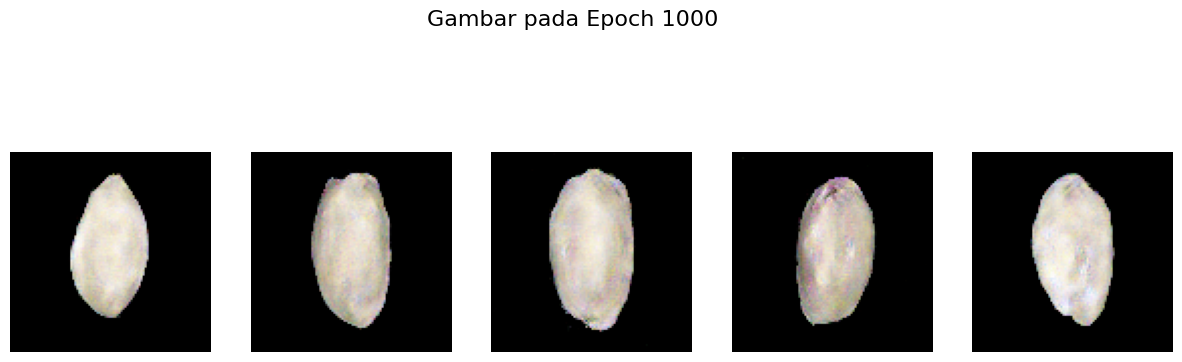

--- Menghitung FID pada epoch 1000... ---
--- FID pada epoch 1000: 701.03 ---
Epoch 1001/15000, Gen Loss: 10.2170, Disc Loss: 0.0079, Time: 0.43 sec
Epoch 1002/15000, Gen Loss: 10.0465, Disc Loss: 0.0057, Time: 0.41 sec
Epoch 1003/15000, Gen Loss: 9.5106, Disc Loss: 0.0375, Time: 0.40 sec
Epoch 1004/15000, Gen Loss: 9.5196, Disc Loss: 0.0282, Time: 0.40 sec
Epoch 1005/15000, Gen Loss: 9.2346, Disc Loss: 0.0391, Time: 0.41 sec
Epoch 1006/15000, Gen Loss: 9.2423, Disc Loss: 0.0096, Time: 0.40 sec
Epoch 1007/15000, Gen Loss: 9.7542, Disc Loss: 0.0108, Time: 0.41 sec
Epoch 1008/15000, Gen Loss: 9.5234, Disc Loss: 0.0074, Time: 0.40 sec
Epoch 1009/15000, Gen Loss: 9.7230, Disc Loss: 0.0060, Time: 0.40 sec
Epoch 1010/15000, Gen Loss: 9.7515, Disc Loss: 0.0340, Time: 0.41 sec
Epoch 1011/15000, Gen Loss: 9.9248, Disc Loss: 0.0247, Time: 0.40 sec
Epoch 1012/15000, Gen Loss: 9.7185, Disc Loss: 0.0148, Time: 0.41 sec
Epoch 1013/15000, Gen Loss: 9.6431, Disc Loss: 0.0152, Time: 0.40 sec
Epoch 1014

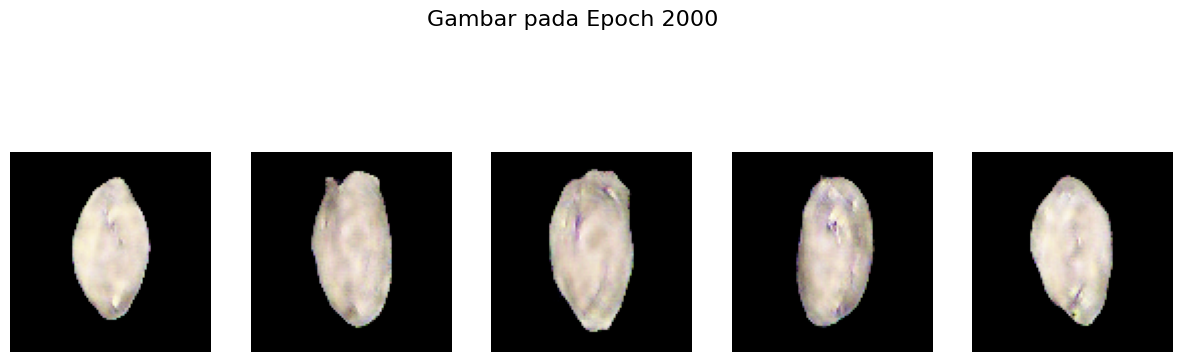

--- Menghitung FID pada epoch 2000... ---
--- FID pada epoch 2000: 858.46 ---
Epoch 2001/15000, Gen Loss: 14.9416, Disc Loss: 0.0099, Time: 0.42 sec
Epoch 2002/15000, Gen Loss: 15.3504, Disc Loss: 0.0016, Time: 0.40 sec
Epoch 2003/15000, Gen Loss: 15.3407, Disc Loss: 0.0009, Time: 0.40 sec
Epoch 2004/15000, Gen Loss: 15.2194, Disc Loss: 0.0074, Time: 0.40 sec
Epoch 2005/15000, Gen Loss: 15.3852, Disc Loss: 0.0022, Time: 0.41 sec
Epoch 2006/15000, Gen Loss: 15.5735, Disc Loss: 0.0103, Time: 0.40 sec
Epoch 2007/15000, Gen Loss: 14.7908, Disc Loss: 0.0012, Time: 0.42 sec
Epoch 2008/15000, Gen Loss: 14.2826, Disc Loss: 0.0271, Time: 0.40 sec
Epoch 2009/15000, Gen Loss: 15.0136, Disc Loss: 0.0038, Time: 0.40 sec
Epoch 2010/15000, Gen Loss: 14.7107, Disc Loss: 0.0017, Time: 0.41 sec
Epoch 2011/15000, Gen Loss: 15.2492, Disc Loss: 0.0009, Time: 0.40 sec
Epoch 2012/15000, Gen Loss: 15.0582, Disc Loss: 0.0021, Time: 0.41 sec
Epoch 2013/15000, Gen Loss: 15.1796, Disc Loss: 0.0026, Time: 0.40 sec

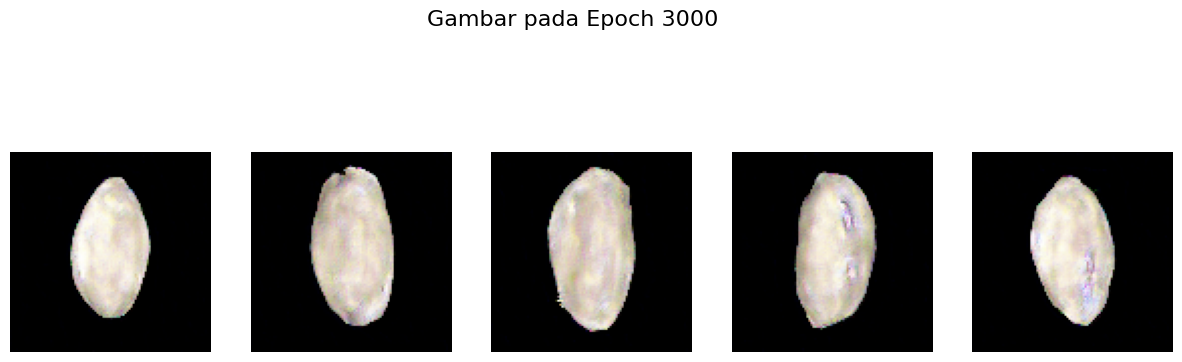

--- Menghitung FID pada epoch 3000... ---
--- FID pada epoch 3000: 687.04 ---
Epoch 3001/15000, Gen Loss: 15.0449, Disc Loss: 0.0125, Time: 0.43 sec
Epoch 3002/15000, Gen Loss: 15.6828, Disc Loss: 0.0138, Time: 0.41 sec
Epoch 3003/15000, Gen Loss: 15.2983, Disc Loss: 0.0009, Time: 0.40 sec
Epoch 3004/15000, Gen Loss: 14.8908, Disc Loss: 0.0095, Time: 0.41 sec
Epoch 3005/15000, Gen Loss: 15.5410, Disc Loss: 0.0097, Time: 0.40 sec
Epoch 3006/15000, Gen Loss: 15.1880, Disc Loss: 0.0025, Time: 0.41 sec
Epoch 3007/15000, Gen Loss: 14.1877, Disc Loss: 0.0123, Time: 0.40 sec
Epoch 3008/15000, Gen Loss: 14.2046, Disc Loss: 0.0219, Time: 0.40 sec
Epoch 3009/15000, Gen Loss: 15.0541, Disc Loss: 0.0205, Time: 0.40 sec
Epoch 3010/15000, Gen Loss: 15.7140, Disc Loss: 0.0140, Time: 0.40 sec
Epoch 3011/15000, Gen Loss: 14.9825, Disc Loss: 0.0121, Time: 0.40 sec
Epoch 3012/15000, Gen Loss: 15.1372, Disc Loss: 0.0070, Time: 0.41 sec
Epoch 3013/15000, Gen Loss: 16.0140, Disc Loss: 0.0108, Time: 0.40 sec

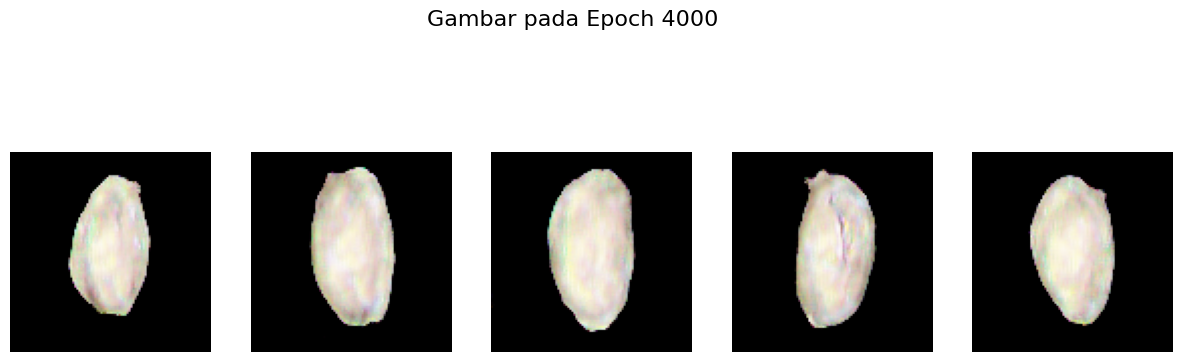

--- Menghitung FID pada epoch 4000... ---
--- FID pada epoch 4000: 855.32 ---
Epoch 4001/15000, Gen Loss: 21.3481, Disc Loss: 0.0039, Time: 0.46 sec
Epoch 4002/15000, Gen Loss: 20.1540, Disc Loss: 0.0504, Time: 0.40 sec
Epoch 4003/15000, Gen Loss: 20.9189, Disc Loss: 0.0152, Time: 0.41 sec
Epoch 4004/15000, Gen Loss: 21.6873, Disc Loss: 0.0373, Time: 0.40 sec
Epoch 4005/15000, Gen Loss: 19.9629, Disc Loss: 0.1195, Time: 0.40 sec
Epoch 4006/15000, Gen Loss: 20.8089, Disc Loss: 0.0185, Time: 0.40 sec
Epoch 4007/15000, Gen Loss: 22.6148, Disc Loss: 0.0406, Time: 0.40 sec
Epoch 4008/15000, Gen Loss: 20.6208, Disc Loss: 0.1431, Time: 0.41 sec
Epoch 4009/15000, Gen Loss: 20.7931, Disc Loss: 0.0305, Time: 0.40 sec
Epoch 4010/15000, Gen Loss: 22.1131, Disc Loss: 0.0044, Time: 0.41 sec
Epoch 4011/15000, Gen Loss: 22.2693, Disc Loss: 0.0379, Time: 0.40 sec
Epoch 4012/15000, Gen Loss: 20.9122, Disc Loss: 0.1131, Time: 0.40 sec
Epoch 4013/15000, Gen Loss: 21.2372, Disc Loss: 0.0752, Time: 0.41 sec

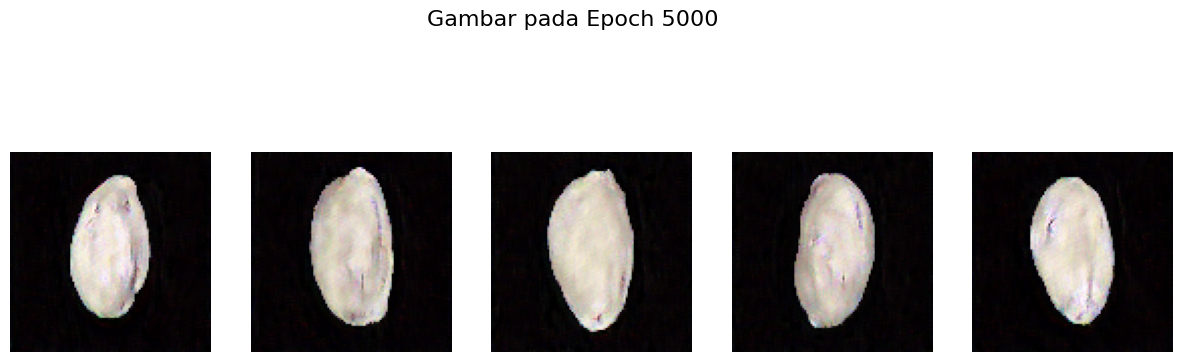

--- Menghitung FID pada epoch 5000... ---
--- FID pada epoch 5000: 834.98 ---
Epoch 5001/15000, Gen Loss: 18.6097, Disc Loss: 0.0022, Time: 0.42 sec
Epoch 5002/15000, Gen Loss: 17.9182, Disc Loss: 0.0035, Time: 0.40 sec
Epoch 5003/15000, Gen Loss: 19.4337, Disc Loss: 0.0020, Time: 0.95 sec
Epoch 5004/15000, Gen Loss: 18.8992, Disc Loss: 0.0027, Time: 0.41 sec
Epoch 5005/15000, Gen Loss: 18.8060, Disc Loss: 0.0007, Time: 0.40 sec
Epoch 5006/15000, Gen Loss: 18.7831, Disc Loss: 0.0036, Time: 0.41 sec
Epoch 5007/15000, Gen Loss: 18.1740, Disc Loss: 0.0021, Time: 0.40 sec
Epoch 5008/15000, Gen Loss: 17.8973, Disc Loss: 0.0115, Time: 0.40 sec
Epoch 5009/15000, Gen Loss: 18.3157, Disc Loss: 0.0075, Time: 0.41 sec
Epoch 5010/15000, Gen Loss: 17.7294, Disc Loss: 0.0039, Time: 0.40 sec
Epoch 5011/15000, Gen Loss: 17.7410, Disc Loss: 0.0336, Time: 0.40 sec
Epoch 5012/15000, Gen Loss: 17.2848, Disc Loss: 0.0041, Time: 0.41 sec
Epoch 5013/15000, Gen Loss: 18.5538, Disc Loss: 0.0069, Time: 0.40 sec

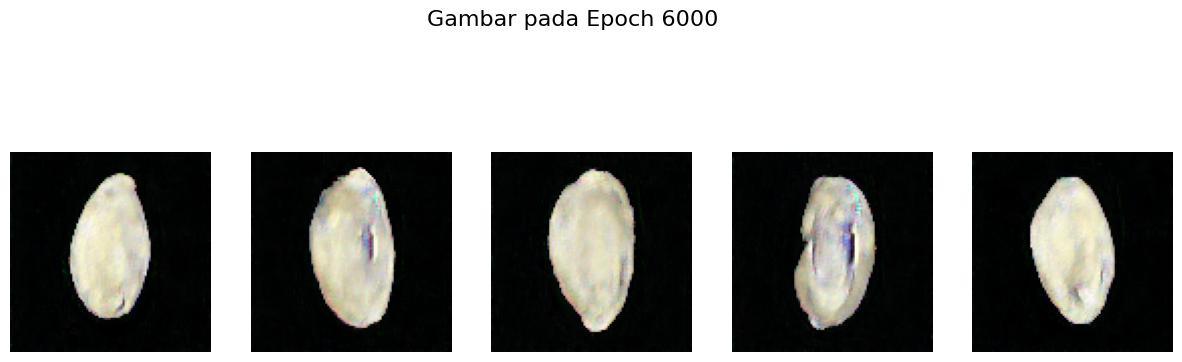

--- Menghitung FID pada epoch 6000... ---
--- FID pada epoch 6000: 823.94 ---
Epoch 6001/15000, Gen Loss: 19.9123, Disc Loss: 0.1210, Time: 0.44 sec
Epoch 6002/15000, Gen Loss: 19.2788, Disc Loss: 0.0101, Time: 0.41 sec
Epoch 6003/15000, Gen Loss: 20.1600, Disc Loss: 0.0008, Time: 0.40 sec
Epoch 6004/15000, Gen Loss: 20.2783, Disc Loss: 0.0109, Time: 0.40 sec
Epoch 6005/15000, Gen Loss: 19.5717, Disc Loss: 0.0011, Time: 0.40 sec
Epoch 6006/15000, Gen Loss: 30.7142, Disc Loss: 0.0618, Time: 0.41 sec
Epoch 6007/15000, Gen Loss: 19.5734, Disc Loss: 0.0030, Time: 0.40 sec
Epoch 6008/15000, Gen Loss: 20.4064, Disc Loss: 0.0115, Time: 0.40 sec
Epoch 6009/15000, Gen Loss: 21.3587, Disc Loss: 0.0048, Time: 0.40 sec
Epoch 6010/15000, Gen Loss: 20.2436, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 6011/15000, Gen Loss: 20.0073, Disc Loss: 0.0004, Time: 0.42 sec
Epoch 6012/15000, Gen Loss: 20.1448, Disc Loss: 0.0011, Time: 0.40 sec
Epoch 6013/15000, Gen Loss: 20.5241, Disc Loss: 0.0033, Time: 0.40 sec

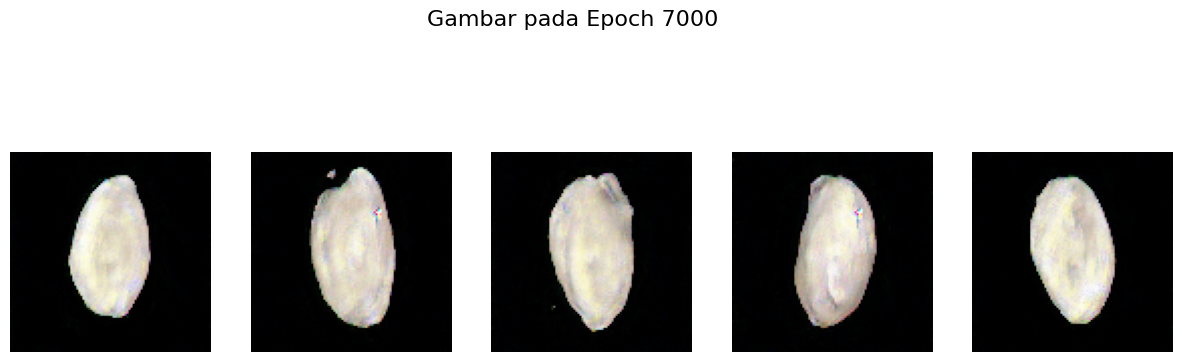

--- Menghitung FID pada epoch 7000... ---
--- FID pada epoch 7000: 719.89 ---
Epoch 7001/15000, Gen Loss: 21.3895, Disc Loss: 0.0116, Time: 0.44 sec
Epoch 7002/15000, Gen Loss: 20.9102, Disc Loss: 0.0080, Time: 0.40 sec
Epoch 7003/15000, Gen Loss: 21.4172, Disc Loss: 0.0016, Time: 0.41 sec
Epoch 7004/15000, Gen Loss: 21.5529, Disc Loss: 0.0194, Time: 0.40 sec
Epoch 7005/15000, Gen Loss: 22.1541, Disc Loss: 0.0278, Time: 0.40 sec
Epoch 7006/15000, Gen Loss: 21.3619, Disc Loss: 0.0009, Time: 0.41 sec
Epoch 7007/15000, Gen Loss: 22.5633, Disc Loss: 0.0057, Time: 0.40 sec
Epoch 7008/15000, Gen Loss: 21.5035, Disc Loss: 0.0110, Time: 0.41 sec
Epoch 7009/15000, Gen Loss: 21.5168, Disc Loss: 0.0055, Time: 0.40 sec
Epoch 7010/15000, Gen Loss: 21.8991, Disc Loss: 0.0010, Time: 0.40 sec
Epoch 7011/15000, Gen Loss: 21.2965, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 7012/15000, Gen Loss: 21.7038, Disc Loss: 0.0098, Time: 0.40 sec
Epoch 7013/15000, Gen Loss: 21.5778, Disc Loss: 0.0007, Time: 0.40 sec

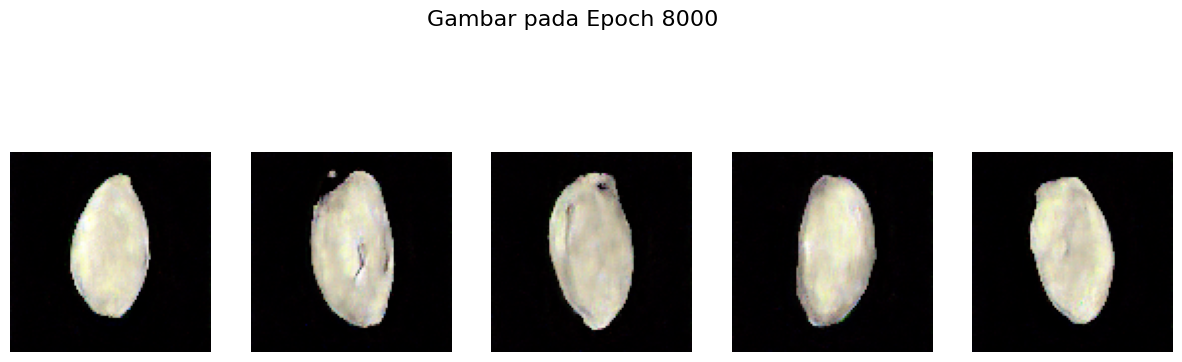

--- Menghitung FID pada epoch 8000... ---
--- FID pada epoch 8000: 764.45 ---
Epoch 8001/15000, Gen Loss: 24.0985, Disc Loss: 0.0052, Time: 0.42 sec
Epoch 8002/15000, Gen Loss: 22.4482, Disc Loss: 0.0036, Time: 0.40 sec
Epoch 8003/15000, Gen Loss: 22.5352, Disc Loss: 0.0096, Time: 0.40 sec
Epoch 8004/15000, Gen Loss: 23.0803, Disc Loss: 0.0073, Time: 0.40 sec
Epoch 8005/15000, Gen Loss: 21.8073, Disc Loss: 0.0006, Time: 0.41 sec
Epoch 8006/15000, Gen Loss: 21.1526, Disc Loss: 0.0002, Time: 0.40 sec
Epoch 8007/15000, Gen Loss: 22.6516, Disc Loss: 0.0059, Time: 0.40 sec
Epoch 8008/15000, Gen Loss: 22.1786, Disc Loss: 0.0024, Time: 0.40 sec
Epoch 8009/15000, Gen Loss: 22.2415, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 8010/15000, Gen Loss: 24.4290, Disc Loss: 0.0005, Time: 0.40 sec
Epoch 8011/15000, Gen Loss: 23.8636, Disc Loss: 0.0001, Time: 0.41 sec
Epoch 8012/15000, Gen Loss: 21.7703, Disc Loss: 0.0095, Time: 0.40 sec
Epoch 8013/15000, Gen Loss: 22.4514, Disc Loss: 0.0002, Time: 0.40 sec

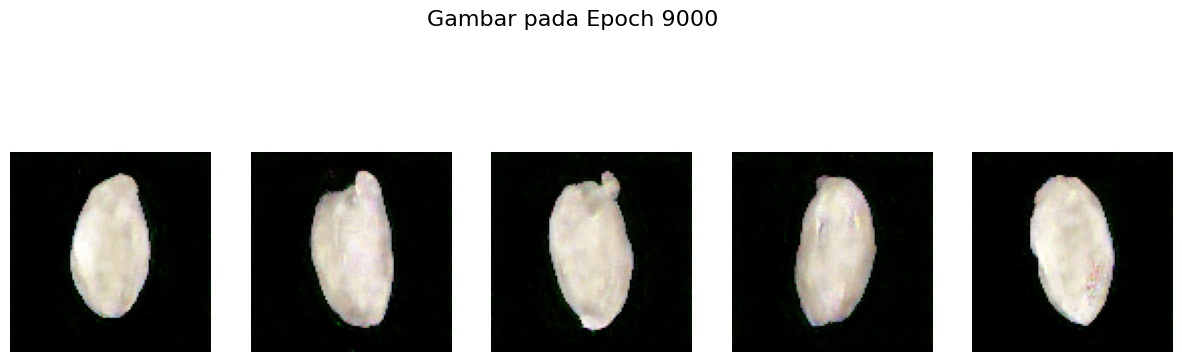

--- Menghitung FID pada epoch 9000... ---
--- FID pada epoch 9000: 803.57 ---
Epoch 9001/15000, Gen Loss: 23.7026, Disc Loss: 0.0003, Time: 0.44 sec
Epoch 9002/15000, Gen Loss: 22.9000, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 9003/15000, Gen Loss: 22.6819, Disc Loss: 0.0296, Time: 0.40 sec
Epoch 9004/15000, Gen Loss: 22.2672, Disc Loss: 0.0069, Time: 0.41 sec
Epoch 9005/15000, Gen Loss: 24.2381, Disc Loss: 0.0035, Time: 0.40 sec
Epoch 9006/15000, Gen Loss: 23.3162, Disc Loss: 0.0043, Time: 0.41 sec
Epoch 9007/15000, Gen Loss: 22.7629, Disc Loss: 0.0002, Time: 0.40 sec
Epoch 9008/15000, Gen Loss: 24.3811, Disc Loss: 0.0047, Time: 0.40 sec
Epoch 9009/15000, Gen Loss: 23.2896, Disc Loss: 0.0009, Time: 0.40 sec
Epoch 9010/15000, Gen Loss: 23.7112, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 9011/15000, Gen Loss: 25.1682, Disc Loss: 0.0021, Time: 0.41 sec
Epoch 9012/15000, Gen Loss: 23.6177, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 9013/15000, Gen Loss: 23.4413, Disc Loss: 0.0004, Time: 0.40 sec

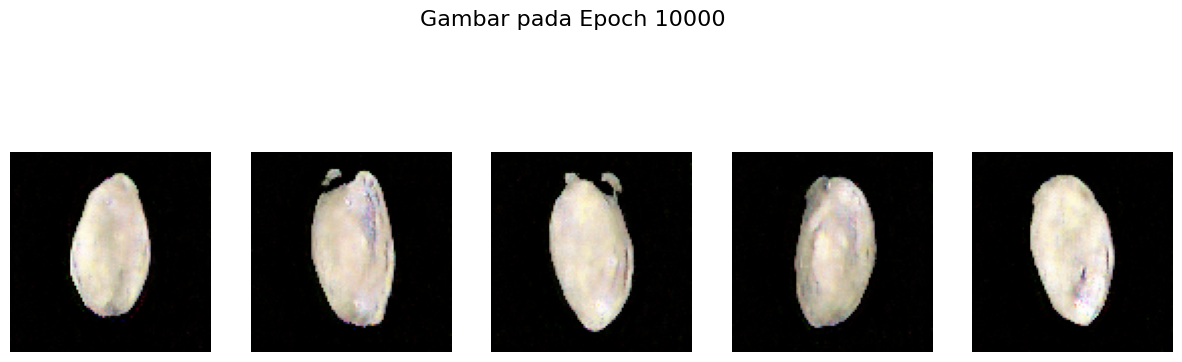

--- Menghitung FID pada epoch 10000... ---
--- FID pada epoch 10000: 789.18 ---
Epoch 10001/15000, Gen Loss: 26.4876, Disc Loss: 0.0021, Time: 0.44 sec
Epoch 10002/15000, Gen Loss: 27.1392, Disc Loss: 0.0006, Time: 0.40 sec
Epoch 10003/15000, Gen Loss: 26.5105, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 10004/15000, Gen Loss: 27.5593, Disc Loss: 0.0046, Time: 0.40 sec
Epoch 10005/15000, Gen Loss: 25.4762, Disc Loss: 0.4785, Time: 0.40 sec
Epoch 10006/15000, Gen Loss: 24.1856, Disc Loss: 0.0053, Time: 0.40 sec
Epoch 10007/15000, Gen Loss: 23.3925, Disc Loss: 0.0014, Time: 0.40 sec
Epoch 10008/15000, Gen Loss: 23.8804, Disc Loss: 0.0033, Time: 0.40 sec
Epoch 10009/15000, Gen Loss: 24.2501, Disc Loss: 0.0025, Time: 0.41 sec
Epoch 10010/15000, Gen Loss: 24.0490, Disc Loss: 0.0055, Time: 0.40 sec
Epoch 10011/15000, Gen Loss: 24.1946, Disc Loss: 0.0068, Time: 0.40 sec
Epoch 10012/15000, Gen Loss: 22.6412, Disc Loss: 0.0008, Time: 0.41 sec
Epoch 10013/15000, Gen Loss: 24.0090, Disc Loss: 0.0013,

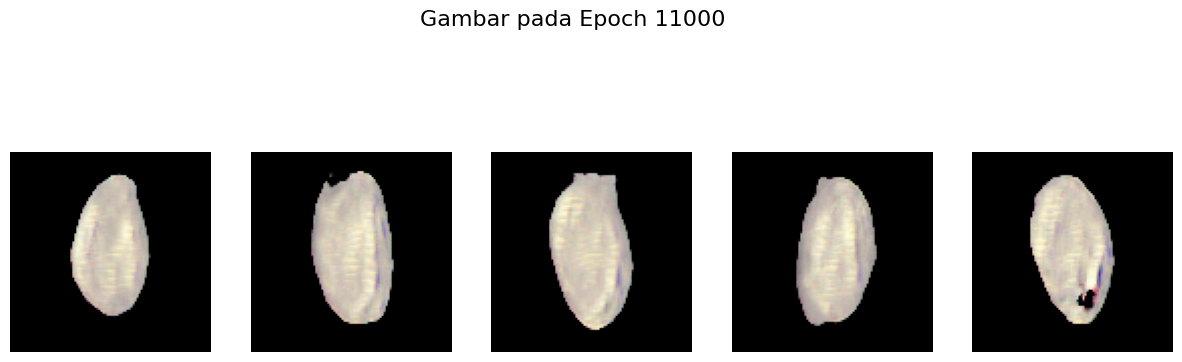

--- Menghitung FID pada epoch 11000... ---
--- FID pada epoch 11000: 910.40 ---
Epoch 11001/15000, Gen Loss: 30.6127, Disc Loss: 0.0143, Time: 0.42 sec
Epoch 11002/15000, Gen Loss: 32.0273, Disc Loss: 0.0014, Time: 0.41 sec
Epoch 11003/15000, Gen Loss: 33.5241, Disc Loss: 0.0413, Time: 0.40 sec
Epoch 11004/15000, Gen Loss: 32.7710, Disc Loss: 0.0195, Time: 0.41 sec
Epoch 11005/15000, Gen Loss: 31.7544, Disc Loss: 0.0101, Time: 0.40 sec
Epoch 11006/15000, Gen Loss: 34.3005, Disc Loss: 0.0284, Time: 0.41 sec
Epoch 11007/15000, Gen Loss: 37.1023, Disc Loss: 0.0073, Time: 0.40 sec
Epoch 11008/15000, Gen Loss: 33.1342, Disc Loss: 0.0323, Time: 0.40 sec
Epoch 11009/15000, Gen Loss: 34.2097, Disc Loss: 0.0064, Time: 0.40 sec
Epoch 11010/15000, Gen Loss: 32.9001, Disc Loss: 0.0051, Time: 0.40 sec
Epoch 11011/15000, Gen Loss: 35.8092, Disc Loss: 0.0190, Time: 0.40 sec
Epoch 11012/15000, Gen Loss: 34.9113, Disc Loss: 0.0000, Time: 0.41 sec
Epoch 11013/15000, Gen Loss: 35.3381, Disc Loss: 0.0086,

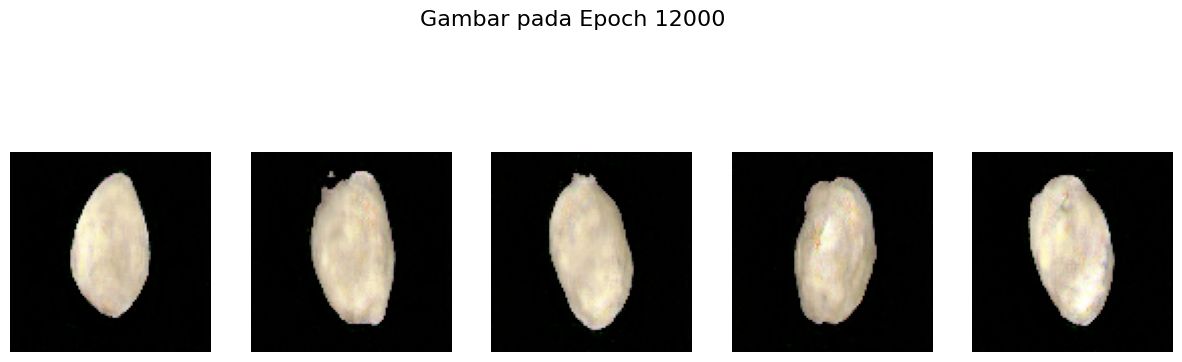

--- Menghitung FID pada epoch 12000... ---
--- FID pada epoch 12000: 829.01 ---
Epoch 12001/15000, Gen Loss: 28.9831, Disc Loss: 0.0000, Time: 0.43 sec
Epoch 12002/15000, Gen Loss: 29.1550, Disc Loss: 0.0002, Time: 0.40 sec
Epoch 12003/15000, Gen Loss: 27.2619, Disc Loss: 0.0063, Time: 0.40 sec
Epoch 12004/15000, Gen Loss: 29.5155, Disc Loss: 0.0078, Time: 0.40 sec
Epoch 12005/15000, Gen Loss: 28.8672, Disc Loss: 0.0000, Time: 0.41 sec
Epoch 12006/15000, Gen Loss: 29.0065, Disc Loss: 0.0000, Time: 0.40 sec
Epoch 12007/15000, Gen Loss: 29.3900, Disc Loss: 0.0002, Time: 0.41 sec
Epoch 12008/15000, Gen Loss: 29.9893, Disc Loss: 0.0003, Time: 0.40 sec
Epoch 12009/15000, Gen Loss: 30.4645, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 12010/15000, Gen Loss: 29.9059, Disc Loss: 0.0000, Time: 0.40 sec
Epoch 12011/15000, Gen Loss: 29.4671, Disc Loss: 0.0000, Time: 0.40 sec
Epoch 12012/15000, Gen Loss: 29.4348, Disc Loss: 0.0003, Time: 0.40 sec
Epoch 12013/15000, Gen Loss: 30.6335, Disc Loss: 0.0001,

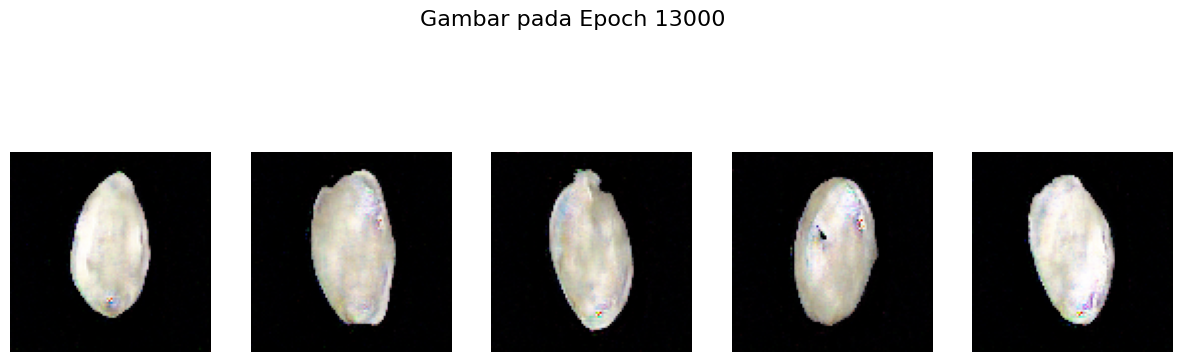

--- Menghitung FID pada epoch 13000... ---
--- FID pada epoch 13000: 838.77 ---
Epoch 13001/15000, Gen Loss: 30.2558, Disc Loss: 0.0010, Time: 0.44 sec
Epoch 13002/15000, Gen Loss: 30.2507, Disc Loss: 0.0005, Time: 0.40 sec
Epoch 13003/15000, Gen Loss: 30.3566, Disc Loss: 0.0000, Time: 0.41 sec
Epoch 13004/15000, Gen Loss: 30.1558, Disc Loss: 0.0011, Time: 0.40 sec
Epoch 13005/15000, Gen Loss: 29.3259, Disc Loss: 0.0100, Time: 0.40 sec
Epoch 13006/15000, Gen Loss: 29.0375, Disc Loss: 0.0081, Time: 0.40 sec
Epoch 13007/15000, Gen Loss: 26.9473, Disc Loss: 0.0130, Time: 0.40 sec
Epoch 13008/15000, Gen Loss: 29.7461, Disc Loss: 0.0008, Time: 0.41 sec
Epoch 13009/15000, Gen Loss: 26.7405, Disc Loss: 0.0000, Time: 0.40 sec
Epoch 13010/15000, Gen Loss: 29.2679, Disc Loss: 0.0085, Time: 0.40 sec
Epoch 13011/15000, Gen Loss: 27.0632, Disc Loss: 0.0153, Time: 0.40 sec
Epoch 13012/15000, Gen Loss: 32.5826, Disc Loss: 0.0003, Time: 0.40 sec
Epoch 13013/15000, Gen Loss: 30.5672, Disc Loss: 0.0000,

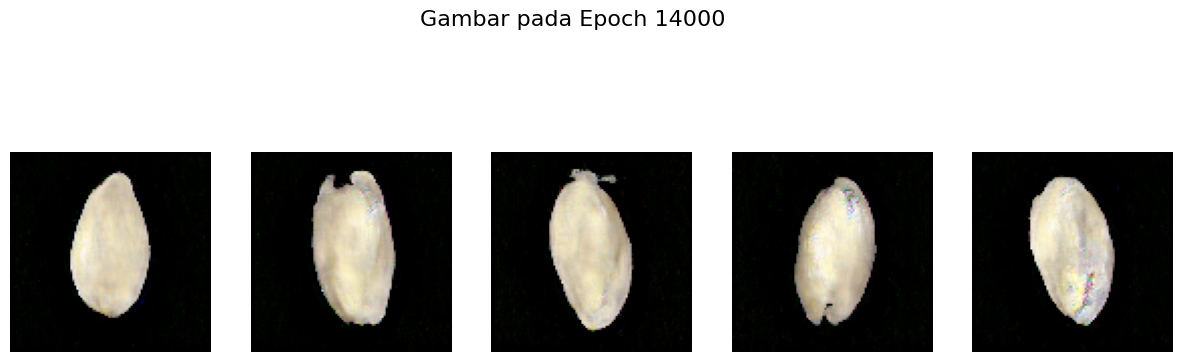

--- Menghitung FID pada epoch 14000... ---
--- FID pada epoch 14000: 773.58 ---
Epoch 14001/15000, Gen Loss: 28.2060, Disc Loss: 0.0001, Time: 0.45 sec
Epoch 14002/15000, Gen Loss: 28.7703, Disc Loss: 0.0000, Time: 0.40 sec
Epoch 14003/15000, Gen Loss: 29.0886, Disc Loss: 0.0003, Time: 0.41 sec
Epoch 14004/15000, Gen Loss: 28.3564, Disc Loss: 0.0001, Time: 0.40 sec
Epoch 14005/15000, Gen Loss: 28.9260, Disc Loss: 0.0008, Time: 0.41 sec
Epoch 14006/15000, Gen Loss: 29.4357, Disc Loss: 0.0220, Time: 0.40 sec
Epoch 14007/15000, Gen Loss: 30.0539, Disc Loss: 0.2854, Time: 0.41 sec
Epoch 14008/15000, Gen Loss: 32.0215, Disc Loss: 0.0544, Time: 0.40 sec
Epoch 14009/15000, Gen Loss: 26.7756, Disc Loss: 0.0012, Time: 0.40 sec
Epoch 14010/15000, Gen Loss: 27.9658, Disc Loss: 0.0012, Time: 0.41 sec
Epoch 14011/15000, Gen Loss: 29.5799, Disc Loss: 0.0050, Time: 0.40 sec
Epoch 14012/15000, Gen Loss: 30.2331, Disc Loss: 0.0008, Time: 0.41 sec
Epoch 14013/15000, Gen Loss: 29.2254, Disc Loss: 0.0017,

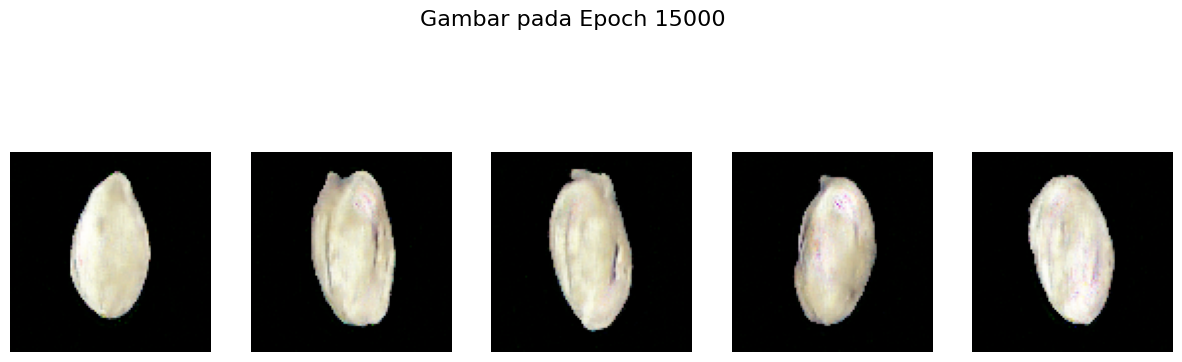

--- Menghitung FID pada epoch 15000... ---
--- FID pada epoch 15000: 747.10 ---

Training Selesai.


In [123]:
history_baseline = train_gan_and_get_history(
    real_dataset,
    EPOCHS_BASELINE,
    generator_baseline,
    discriminator_baseline,
    optimizer_gen,  # Gunakan optimizer khusus baseline
    optimizer_disc, # Gunakan optimizer khusus baseline
    loss_fn,
    seed_for_viz
)

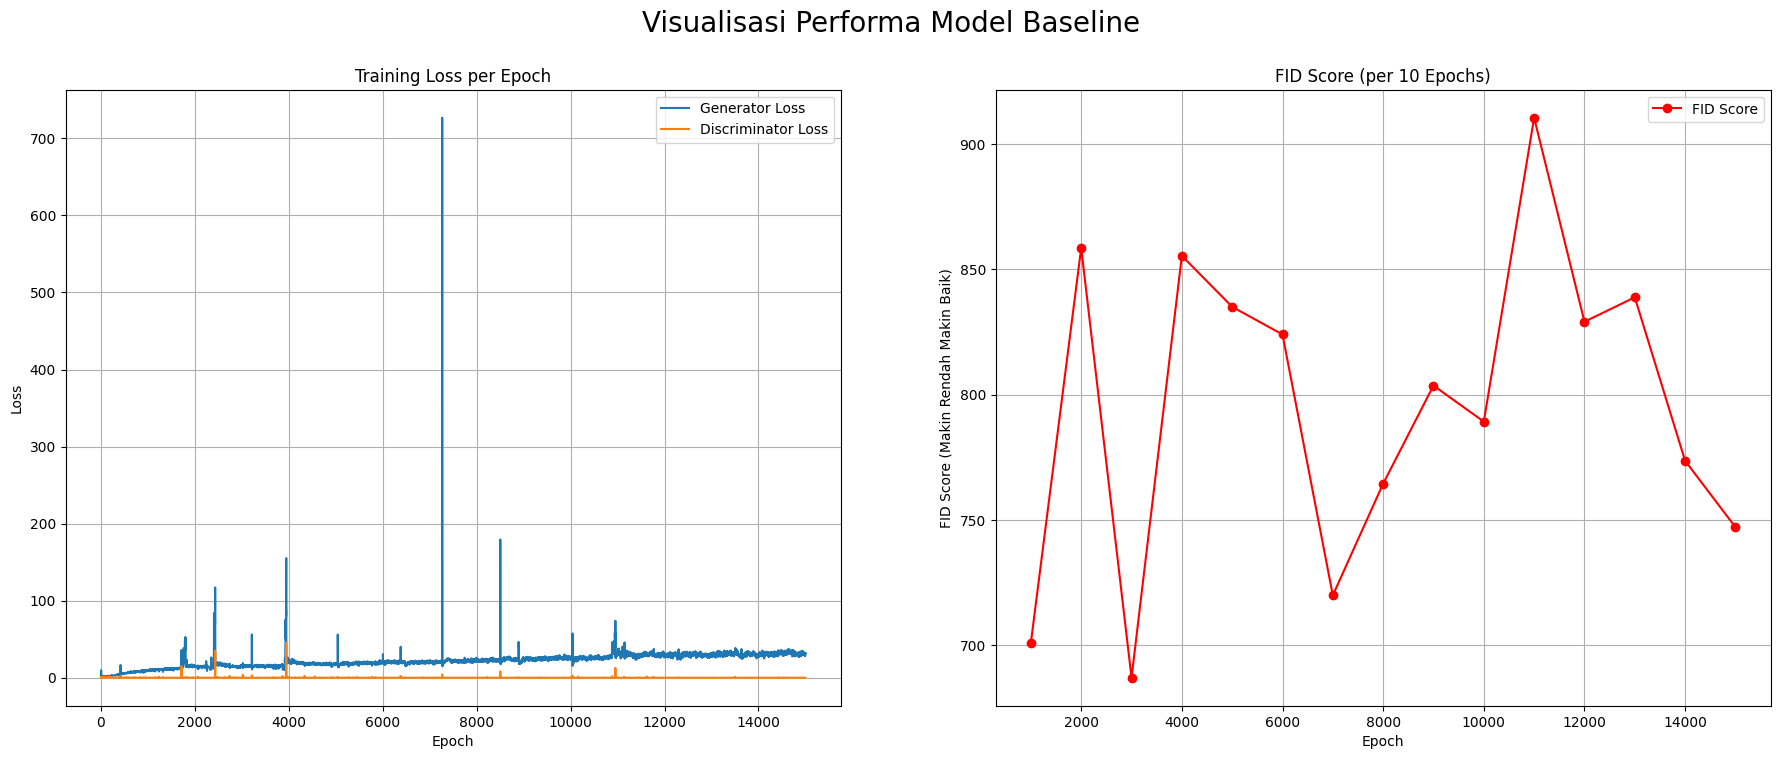

In [124]:
# Tampilkan plot histori untuk model baseline
plot_history(history_baseline, "Baseline")

---
**1. Training Loss per Epoch**

* **Generator Loss (biru)** terlihat cukup fluktuatif, dengan beberapa lonjakan ekstrem (misalnya di sekitar epoch 7500 dan 9000). Hal ini bisa mengindikasikan **instabilitas dalam proses pelatihan**, yang umum terjadi pada model GAN.
* **Discriminator Loss (oranye)** cenderung lebih stabil dan relatif kecil. Ini bisa berarti bahwa discriminator **lebih cepat belajar** dibanding generator.
* Idealnya, kedua loss seharusnya **berfluktuasi dalam keseimbangan**, namun dalam grafik ini, generator tampak kesulitan mengejar kinerja discriminator, yang bisa menyebabkan **mode collapse** atau **hasil gambar yang kurang realistis**.

---

**2. FID Score (setiap 10 Epoch)**

* FID (Fréchet Inception Distance) mengukur kualitas gambar yang dihasilkan (semakin rendah, semakin baik).
* Skor FID **berfluktuasi cukup besar**, dari sekitar **690 hingga di atas 910**, yang menunjukkan **konsistensi kualitas gambar belum stabil**.
* FID tertinggi (terburuk) terjadi di sekitar **epoch 11000**, sedangkan nilai terbaik muncul sekitar **epoch 3000 dan 7000**.
* Hal ini menguatkan temuan dari grafik loss bahwa pelatihan GAN ini **belum konvergen dengan baik** dan model masih mengalami **ketidakstabilan dalam menghasilkan gambar**.

---
---

**Kesimpulan**

Model baseline GAN ini menunjukkan indikasi **instabilitas pelatihan**, terutama dari lonjakan pada generator loss dan fluktuasi besar pada FID score. Perlu dilakukan tuning lebih lanjut, seperti:

* Penyesuaian learning rate,
* Tambahan teknik stabilisasi (misalnya, label smoothing, gradient penalty),
* Arsitektur yang lebih stabil (misal WGAN, atau menggunakan batch norm / spectral norm).

Model belum bisa diandalkan menghasilkan gambar dengan kualitas konsisten berdasarkan metrik FID dan perilaku loss-nya.


## Modified GAN (DCGAN)

### Generator

In [125]:
def build_generator_modified(latent_dim=LATENT_DIM):
    noise_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(25 * 25 * 128, use_bias=False)(noise_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((25, 25, 128))(x)
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    output_image = layers.Conv2DTranspose(3, (5, 5), padding='same', activation='tanh')(x)
    model = models.Model(noise_input, output_image, name="generator_modified")
    return model

### Discriminator

In [126]:
def build_discriminator_modified(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    image_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    output_prob = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(image_input, output_prob, name="discriminator_modified")
    return model

### Model

In [127]:
generator_modified = build_generator_modified()
discriminator_modified = build_discriminator_modified()

optimizer_gen_mod = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_disc_mod = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator_modified.compile(optimizer=optimizer_disc, loss=loss_fn, metrics=['accuracy'])

print("--- Arsitektur Generator Modified ---")
generator_modified.summary()
print("\n--- Arsitektur Discriminator Modified ---")
discriminator_modified.summary()

--- Arsitektur Generator Modified ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator_modified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 80000)          │     8,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1136        │ (None, 80000)          │       320,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 50, 50, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1137        │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 100, 100, 32)   │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1138        │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 100, 100, 3)    │         2,403 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,578,787 (32.73 MB)

 Trainable params: 8,418,595 (32.11 MB)

 Non-trainable params: 160,192 (625.75 KB)


--- Arsitektur Discriminator Modified ---


Model: "discriminator_modified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1202 (Conv2D)            │ (None, 50, 50, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1203 (Conv2D)            │ (None, 25, 25, 128)    │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1139        │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │        80,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,468,357 (5.60 MB)

 Trainable params: 289,921 (1.11 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,178,180 (4.49 MB)

### Function Training & Evaluate

In [128]:
# --- Fungsi untuk menampilkan gambar ---
def generate_and_show_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(15, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(1, 5, i + 1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2.0)
        plt.axis('off')
    plt.suptitle(f'Gambar pada Epoch {epoch}', fontsize=16)
    plt.show()

In [129]:
# --- Fungsi untuk menghitung FID ---
def calculate_fid(inception_model, real_images, generated_images):
    real_images_uint8 = ((real_images * 127.5) + 127.5).astype(np.uint8)
    generated_images_uint8 = ((generated_images * 127.5) + 127.5).astype(np.uint8)
    real_processed = preprocess_input(real_images_uint8)
    gen_processed = preprocess_input(generated_images_uint8)
    act_real = inception_model.predict(real_processed, verbose=0)
    act_gen = inception_model.predict(gen_processed, verbose=0)
    mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = act_gen.mean(axis=0), np.cov(act_gen, rowvar=False)
    ssdiff = np.sum((mu_real - mu_gen)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean): covmean = covmean.real
    fid_score = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid_score

In [130]:
# --- Fungsi untuk membuat plot histori ---
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
    fig.suptitle(f'Visualisasi Performa Model {model_name}', fontsize=20)

    # Plot Loss
    ax1.plot(history['gen_loss'], label='Generator Loss')
    ax1.plot(history['disc_loss'], label='Discriminator Loss')
    ax1.set_title('Training Loss per Epoch'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
    ax1.legend(); ax1.grid(True)

    # Plot FID
    if history.get('fid_scores'):
        ax2.plot(history['fid_epochs'], history['fid_scores'], marker='o', linestyle='-', color='r', label='FID Score')
        ax2.set_title('FID Score (per 10 Epochs)'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('FID Score (Makin Rendah Makin Baik)')
        ax2.legend(); ax2.grid(True)
    else:
        ax2.text(0.5, 0.5, 'Tidak ada data FID.', horizontalalignment='center'); ax2.set_title('FID Score')

    plt.show()

In [131]:
# --- Fungsi untuk satu langkah training ---
@tf.function
def train_step(images, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        real_loss = loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [132]:
def train_gan_and_get_history(dataset, epochs, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn, test_seed):
    history = {'gen_loss': [], 'disc_loss': [], 'fid_scores': [], 'fid_epochs': []}
    inception_model_for_eval = InceptionV3(include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    real_images_for_eval = np.concatenate([x.numpy() for x in dataset.take(8)], axis=0)

    print(f"\nMemulai Training untuk {generator.name}...")
    for epoch in range(epochs):
        start = time.time()
        epoch_gen_losses, epoch_disc_losses = [], []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn)
            epoch_gen_losses.append(gen_loss); epoch_disc_losses.append(disc_loss)

        avg_gen_loss = np.mean(epoch_gen_losses); avg_disc_loss = np.mean(epoch_disc_losses)
        history['gen_loss'].append(avg_gen_loss); history['disc_loss'].append(avg_disc_loss)

        print (f'Epoch {epoch + 1}/{epochs}, Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}, Time: {time.time()-start:.2f} sec')

        current_epoch = epoch + 1
        if current_epoch % 1000 == 0:

            generate_and_show_images(generator, current_epoch, test_seed)
            print(f"--- Menghitung FID pada epoch {current_epoch}... ---")
            generated_images = generator.predict(np.random.normal(0, 1, (real_images_for_eval.shape[0], LATENT_DIM)), verbose=0)
            fid_score = calculate_fid(inception_model_for_eval, real_images_for_eval, generated_images)
            history['fid_scores'].append(fid_score); history['fid_epochs'].append(current_epoch)
            print(f"--- FID pada epoch {current_epoch}: {fid_score:.2f} ---")

    print("\nTraining Selesai.")
    return history

### Evaluation Training Model Modified

In [133]:
print("--- MEMULAI PROSES TRAINING MODEL MODIFIED ---")
EPOCHS_MODIFIED = 15000
seed_for_viz = tf.random.normal([5, LATENT_DIM])

--- MEMULAI PROSES TRAINING MODEL MODIFIED ---



Memulai Training untuk generator_modified...
Epoch 1/15000, Gen Loss: 4.0124, Disc Loss: 0.1134, Time: 5.66 sec
Epoch 2/15000, Gen Loss: 6.3553, Disc Loss: 1.5709, Time: 0.44 sec
Epoch 3/15000, Gen Loss: 3.7127, Disc Loss: 3.0955, Time: 0.42 sec
Epoch 4/15000, Gen Loss: 1.9824, Disc Loss: 1.7276, Time: 0.43 sec
Epoch 5/15000, Gen Loss: 2.1633, Disc Loss: 1.4619, Time: 0.42 sec
Epoch 6/15000, Gen Loss: 2.1225, Disc Loss: 1.3466, Time: 0.42 sec
Epoch 7/15000, Gen Loss: 1.9657, Disc Loss: 1.2752, Time: 0.43 sec
Epoch 8/15000, Gen Loss: 2.0836, Disc Loss: 1.1330, Time: 0.42 sec
Epoch 9/15000, Gen Loss: 1.9711, Disc Loss: 1.1012, Time: 0.44 sec
Epoch 10/15000, Gen Loss: 1.9678, Disc Loss: 1.1531, Time: 0.42 sec
Epoch 11/15000, Gen Loss: 1.9152, Disc Loss: 0.9631, Time: 0.42 sec
Epoch 12/15000, Gen Loss: 2.1971, Disc Loss: 1.2057, Time: 0.44 sec
Epoch 13/15000, Gen Loss: 2.0066, Disc Loss: 1.0903, Time: 0.42 sec
Epoch 14/15000, Gen Loss: 1.9003, Disc Loss: 0.9764, Time: 0.44 sec
Epoch 15/15

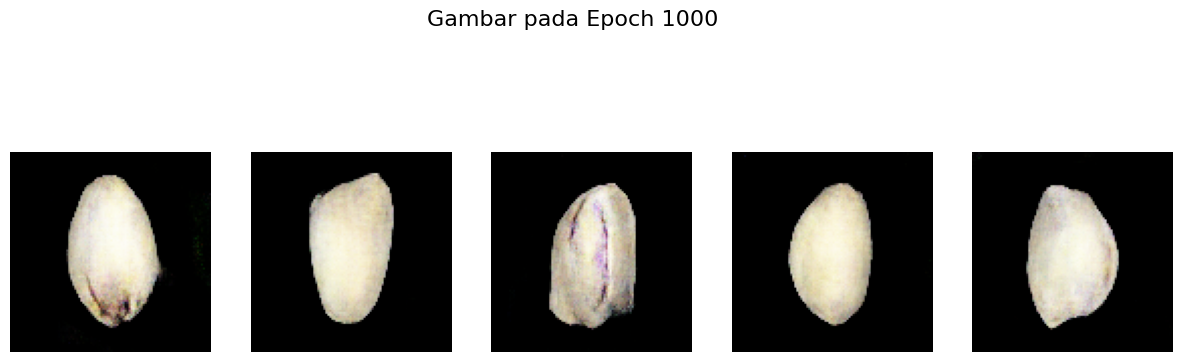

--- Menghitung FID pada epoch 1000... ---
--- FID pada epoch 1000: 591.25 ---
Epoch 1001/15000, Gen Loss: 4.2930, Disc Loss: 0.1213, Time: 0.46 sec
Epoch 1002/15000, Gen Loss: 4.3775, Disc Loss: 0.1157, Time: 0.43 sec
Epoch 1003/15000, Gen Loss: 4.2208, Disc Loss: 0.1275, Time: 0.42 sec
Epoch 1004/15000, Gen Loss: 4.3481, Disc Loss: 0.1287, Time: 0.98 sec
Epoch 1005/15000, Gen Loss: 4.4105, Disc Loss: 0.1070, Time: 0.43 sec
Epoch 1006/15000, Gen Loss: 4.5025, Disc Loss: 0.1081, Time: 0.42 sec
Epoch 1007/15000, Gen Loss: 4.4371, Disc Loss: 0.1255, Time: 0.42 sec
Epoch 1008/15000, Gen Loss: 4.3547, Disc Loss: 0.1702, Time: 0.43 sec
Epoch 1009/15000, Gen Loss: 4.4814, Disc Loss: 0.1276, Time: 0.42 sec
Epoch 1010/15000, Gen Loss: 4.4856, Disc Loss: 0.1107, Time: 0.43 sec
Epoch 1011/15000, Gen Loss: 4.4797, Disc Loss: 0.1083, Time: 0.42 sec
Epoch 1012/15000, Gen Loss: 4.6130, Disc Loss: 0.0914, Time: 0.42 sec
Epoch 1013/15000, Gen Loss: 4.4928, Disc Loss: 0.1240, Time: 0.44 sec
Epoch 1014/1

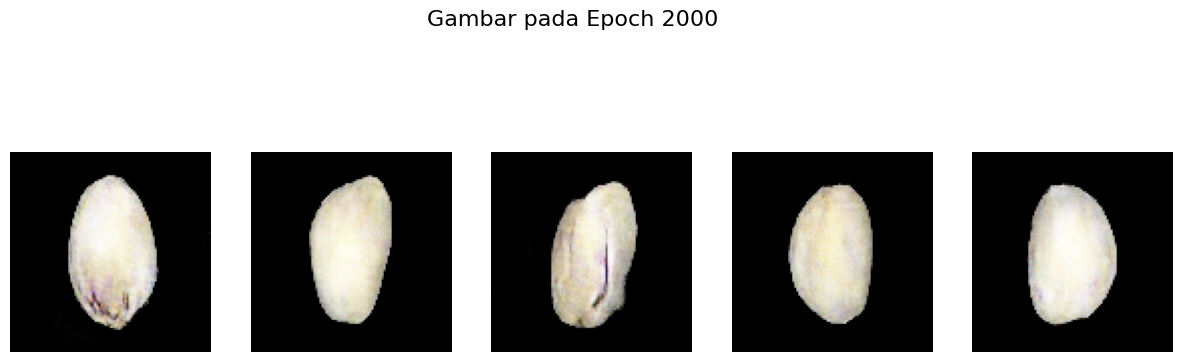

--- Menghitung FID pada epoch 2000... ---
--- FID pada epoch 2000: 527.04 ---
Epoch 2001/15000, Gen Loss: 6.5810, Disc Loss: 0.0279, Time: 0.47 sec
Epoch 2002/15000, Gen Loss: 6.7927, Disc Loss: 0.0357, Time: 0.43 sec
Epoch 2003/15000, Gen Loss: 6.7039, Disc Loss: 0.0285, Time: 0.42 sec
Epoch 2004/15000, Gen Loss: 6.7778, Disc Loss: 0.0380, Time: 0.42 sec
Epoch 2005/15000, Gen Loss: 6.6675, Disc Loss: 0.0306, Time: 0.43 sec
Epoch 2006/15000, Gen Loss: 6.7545, Disc Loss: 0.0367, Time: 0.42 sec
Epoch 2007/15000, Gen Loss: 6.6543, Disc Loss: 0.0376, Time: 0.43 sec
Epoch 2008/15000, Gen Loss: 6.7807, Disc Loss: 0.0381, Time: 0.42 sec
Epoch 2009/15000, Gen Loss: 6.8928, Disc Loss: 7.0986, Time: 0.42 sec
Epoch 2010/15000, Gen Loss: 4.3291, Disc Loss: 3.2041, Time: 0.43 sec
Epoch 2011/15000, Gen Loss: 4.4677, Disc Loss: 1.7066, Time: 0.42 sec
Epoch 2012/15000, Gen Loss: 4.9374, Disc Loss: 0.2635, Time: 0.43 sec
Epoch 2013/15000, Gen Loss: 5.1935, Disc Loss: 0.1775, Time: 0.42 sec
Epoch 2014/1

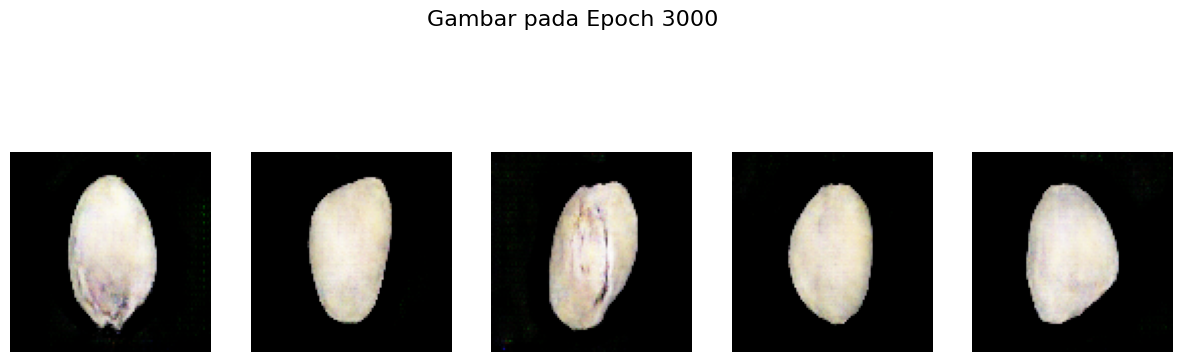

--- Menghitung FID pada epoch 3000... ---
--- FID pada epoch 3000: 664.51 ---
Epoch 3001/15000, Gen Loss: 7.3385, Disc Loss: 0.0189, Time: 0.48 sec
Epoch 3002/15000, Gen Loss: 7.3848, Disc Loss: 0.0216, Time: 0.43 sec
Epoch 3003/15000, Gen Loss: 7.3845, Disc Loss: 0.0210, Time: 0.42 sec
Epoch 3004/15000, Gen Loss: 7.5266, Disc Loss: 0.0348, Time: 0.44 sec
Epoch 3005/15000, Gen Loss: 7.3736, Disc Loss: 0.0177, Time: 0.42 sec
Epoch 3006/15000, Gen Loss: 7.5500, Disc Loss: 0.0256, Time: 0.43 sec
Epoch 3007/15000, Gen Loss: 7.6220, Disc Loss: 0.0227, Time: 0.42 sec
Epoch 3008/15000, Gen Loss: 7.5215, Disc Loss: 0.0167, Time: 0.42 sec
Epoch 3009/15000, Gen Loss: 7.4839, Disc Loss: 0.0195, Time: 0.43 sec
Epoch 3010/15000, Gen Loss: 7.5495, Disc Loss: 0.0163, Time: 0.42 sec
Epoch 3011/15000, Gen Loss: 7.6367, Disc Loss: 0.0186, Time: 0.43 sec
Epoch 3012/15000, Gen Loss: 7.7242, Disc Loss: 0.0172, Time: 0.42 sec
Epoch 3013/15000, Gen Loss: 7.6266, Disc Loss: 0.0218, Time: 0.43 sec
Epoch 3014/1

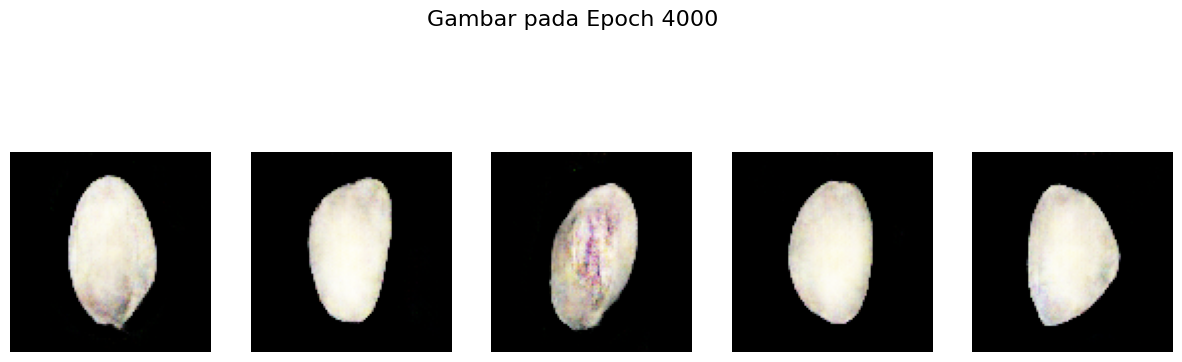

--- Menghitung FID pada epoch 4000... ---
--- FID pada epoch 4000: 815.84 ---
Epoch 4001/15000, Gen Loss: 8.0814, Disc Loss: 0.0241, Time: 0.47 sec
Epoch 4002/15000, Gen Loss: 8.3755, Disc Loss: 0.0203, Time: 0.43 sec
Epoch 4003/15000, Gen Loss: 8.3449, Disc Loss: 0.0168, Time: 0.42 sec
Epoch 4004/15000, Gen Loss: 8.3242, Disc Loss: 0.0223, Time: 0.43 sec
Epoch 4005/15000, Gen Loss: 8.1477, Disc Loss: 0.0204, Time: 0.42 sec
Epoch 4006/15000, Gen Loss: 8.2065, Disc Loss: 0.0199, Time: 0.44 sec
Epoch 4007/15000, Gen Loss: 8.1729, Disc Loss: 0.0142, Time: 0.42 sec
Epoch 4008/15000, Gen Loss: 8.2775, Disc Loss: 0.0140, Time: 0.42 sec
Epoch 4009/15000, Gen Loss: 8.0544, Disc Loss: 0.0174, Time: 0.43 sec
Epoch 4010/15000, Gen Loss: 7.8329, Disc Loss: 0.0139, Time: 0.42 sec
Epoch 4011/15000, Gen Loss: 8.0221, Disc Loss: 0.0181, Time: 0.43 sec
Epoch 4012/15000, Gen Loss: 7.8474, Disc Loss: 0.0284, Time: 0.42 sec
Epoch 4013/15000, Gen Loss: 7.9990, Disc Loss: 0.0164, Time: 0.42 sec
Epoch 4014/1

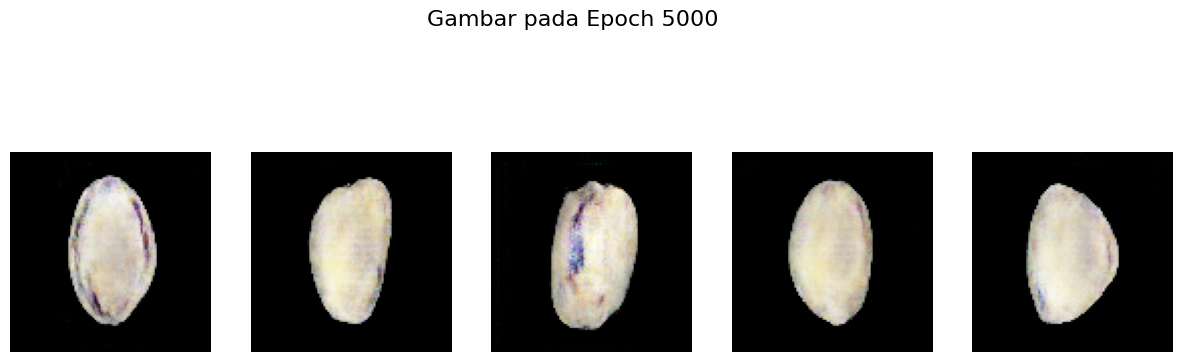

--- Menghitung FID pada epoch 5000... ---
--- FID pada epoch 5000: 695.41 ---
Epoch 5001/15000, Gen Loss: 9.6014, Disc Loss: 0.0065, Time: 0.46 sec
Epoch 5002/15000, Gen Loss: 9.4987, Disc Loss: 0.0084, Time: 0.43 sec
Epoch 5003/15000, Gen Loss: 9.5051, Disc Loss: 0.0145, Time: 0.42 sec
Epoch 5004/15000, Gen Loss: 9.5403, Disc Loss: 0.0090, Time: 0.43 sec
Epoch 5005/15000, Gen Loss: 9.8187, Disc Loss: 0.0139, Time: 0.42 sec
Epoch 5006/15000, Gen Loss: 8.9434, Disc Loss: 0.0166, Time: 0.43 sec
Epoch 5007/15000, Gen Loss: 9.4516, Disc Loss: 0.0161, Time: 0.42 sec
Epoch 5008/15000, Gen Loss: 9.7872, Disc Loss: 0.0195, Time: 0.42 sec
Epoch 5009/15000, Gen Loss: 9.1912, Disc Loss: 0.0723, Time: 0.44 sec
Epoch 5010/15000, Gen Loss: 9.6241, Disc Loss: 0.0476, Time: 0.42 sec
Epoch 5011/15000, Gen Loss: 9.4865, Disc Loss: 0.0483, Time: 0.43 sec
Epoch 5012/15000, Gen Loss: 9.6957, Disc Loss: 0.0246, Time: 0.42 sec
Epoch 5013/15000, Gen Loss: 9.5388, Disc Loss: 0.0195, Time: 0.43 sec
Epoch 5014/1

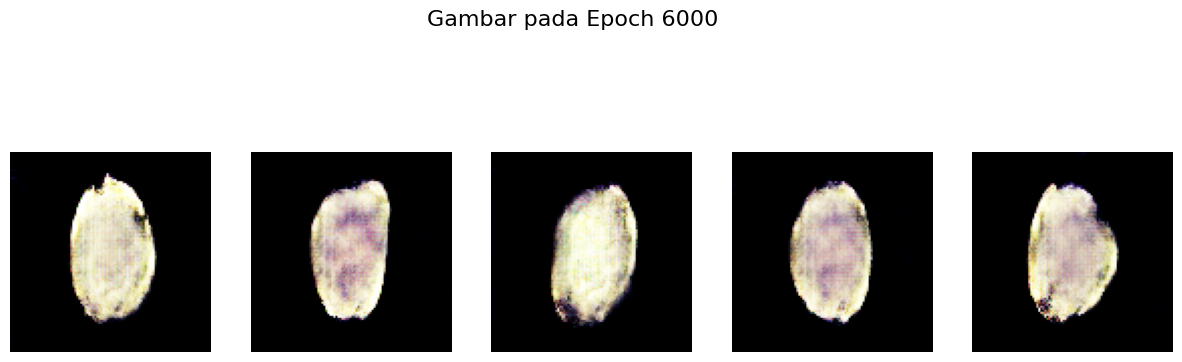

--- Menghitung FID pada epoch 6000... ---
--- FID pada epoch 6000: 918.89 ---
Epoch 6001/15000, Gen Loss: 11.1928, Disc Loss: 0.0067, Time: 0.48 sec
Epoch 6002/15000, Gen Loss: 13.9986, Disc Loss: 0.0210, Time: 0.42 sec
Epoch 6003/15000, Gen Loss: 12.4269, Disc Loss: 0.0028, Time: 0.43 sec
Epoch 6004/15000, Gen Loss: 11.9333, Disc Loss: 0.0103, Time: 0.42 sec
Epoch 6005/15000, Gen Loss: 11.2116, Disc Loss: 0.0052, Time: 0.42 sec
Epoch 6006/15000, Gen Loss: 10.5080, Disc Loss: 0.0099, Time: 0.43 sec
Epoch 6007/15000, Gen Loss: 11.1101, Disc Loss: 0.0057, Time: 0.42 sec
Epoch 6008/15000, Gen Loss: 10.5886, Disc Loss: 0.0097, Time: 0.44 sec
Epoch 6009/15000, Gen Loss: 11.0674, Disc Loss: 0.0084, Time: 0.42 sec
Epoch 6010/15000, Gen Loss: 11.5755, Disc Loss: 0.0073, Time: 0.43 sec
Epoch 6011/15000, Gen Loss: 10.0641, Disc Loss: 0.0053, Time: 0.42 sec
Epoch 6012/15000, Gen Loss: 12.7303, Disc Loss: 1.0096, Time: 0.42 sec
Epoch 6013/15000, Gen Loss: 12.8364, Disc Loss: 0.1408, Time: 0.42 sec

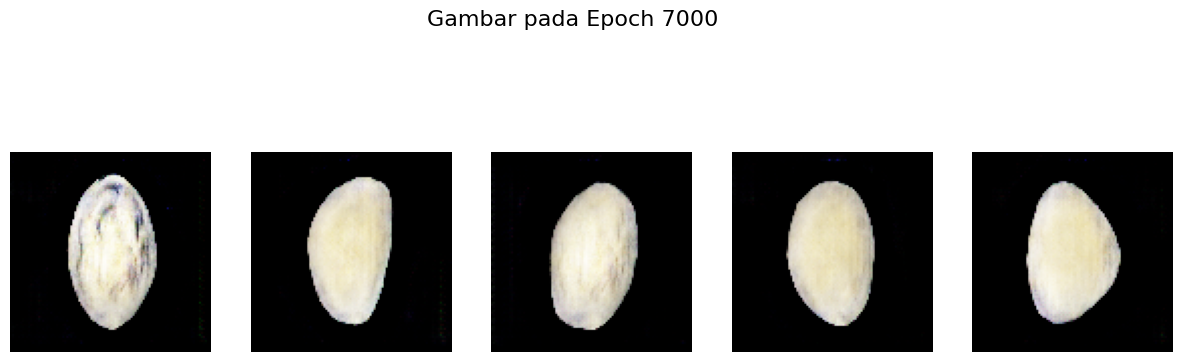

--- Menghitung FID pada epoch 7000... ---
--- FID pada epoch 7000: 847.44 ---
Epoch 7001/15000, Gen Loss: 11.3306, Disc Loss: 0.0107, Time: 0.47 sec
Epoch 7002/15000, Gen Loss: 11.2341, Disc Loss: 0.0058, Time: 0.42 sec
Epoch 7003/15000, Gen Loss: 11.2276, Disc Loss: 0.0071, Time: 0.44 sec
Epoch 7004/15000, Gen Loss: 11.5256, Disc Loss: 0.0108, Time: 0.42 sec
Epoch 7005/15000, Gen Loss: 11.3891, Disc Loss: 0.0073, Time: 0.42 sec
Epoch 7006/15000, Gen Loss: 11.4436, Disc Loss: 0.0108, Time: 0.43 sec
Epoch 7007/15000, Gen Loss: 11.4392, Disc Loss: 0.0119, Time: 0.42 sec
Epoch 7008/15000, Gen Loss: 12.1927, Disc Loss: 0.0047, Time: 0.44 sec
Epoch 7009/15000, Gen Loss: 11.8286, Disc Loss: 0.0032, Time: 0.42 sec
Epoch 7010/15000, Gen Loss: 11.2481, Disc Loss: 0.0043, Time: 0.42 sec
Epoch 7011/15000, Gen Loss: 11.1456, Disc Loss: 0.0063, Time: 0.43 sec
Epoch 7012/15000, Gen Loss: 14.3051, Disc Loss: 1.2833, Time: 0.42 sec
Epoch 7013/15000, Gen Loss: 14.0329, Disc Loss: 0.3525, Time: 0.43 sec

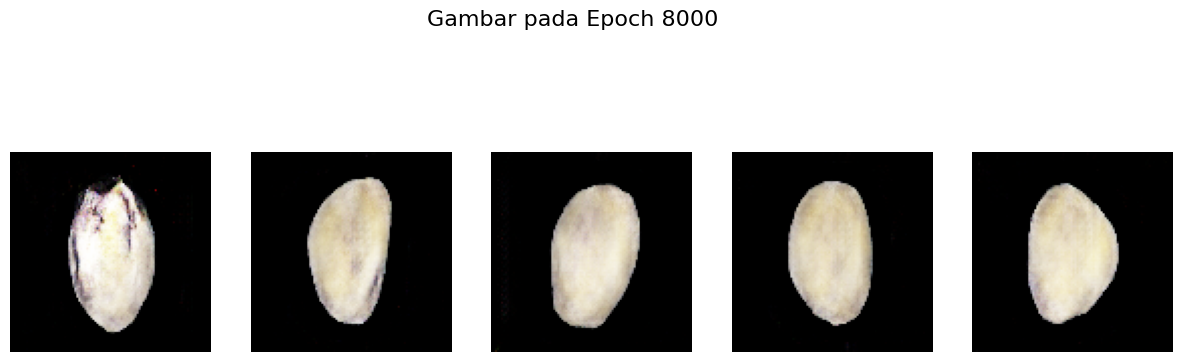

--- Menghitung FID pada epoch 8000... ---
--- FID pada epoch 8000: 774.73 ---
Epoch 8001/15000, Gen Loss: 12.1100, Disc Loss: 0.0200, Time: 0.47 sec
Epoch 8002/15000, Gen Loss: 11.3283, Disc Loss: 0.0115, Time: 0.42 sec
Epoch 8003/15000, Gen Loss: 11.4570, Disc Loss: 0.0060, Time: 0.43 sec
Epoch 8004/15000, Gen Loss: 12.2250, Disc Loss: 0.0298, Time: 0.42 sec
Epoch 8005/15000, Gen Loss: 12.4484, Disc Loss: 0.0099, Time: 0.43 sec
Epoch 8006/15000, Gen Loss: 12.6763, Disc Loss: 0.0104, Time: 0.42 sec
Epoch 8007/15000, Gen Loss: 12.4511, Disc Loss: 0.0105, Time: 0.42 sec
Epoch 8008/15000, Gen Loss: 11.7925, Disc Loss: 0.0142, Time: 0.43 sec
Epoch 8009/15000, Gen Loss: 12.3374, Disc Loss: 0.0089, Time: 0.42 sec
Epoch 8010/15000, Gen Loss: 12.1579, Disc Loss: 0.0099, Time: 0.43 sec
Epoch 8011/15000, Gen Loss: 12.2870, Disc Loss: 0.0107, Time: 0.42 sec
Epoch 8012/15000, Gen Loss: 11.8640, Disc Loss: 0.0121, Time: 0.44 sec
Epoch 8013/15000, Gen Loss: 12.0520, Disc Loss: 0.0194, Time: 0.42 sec

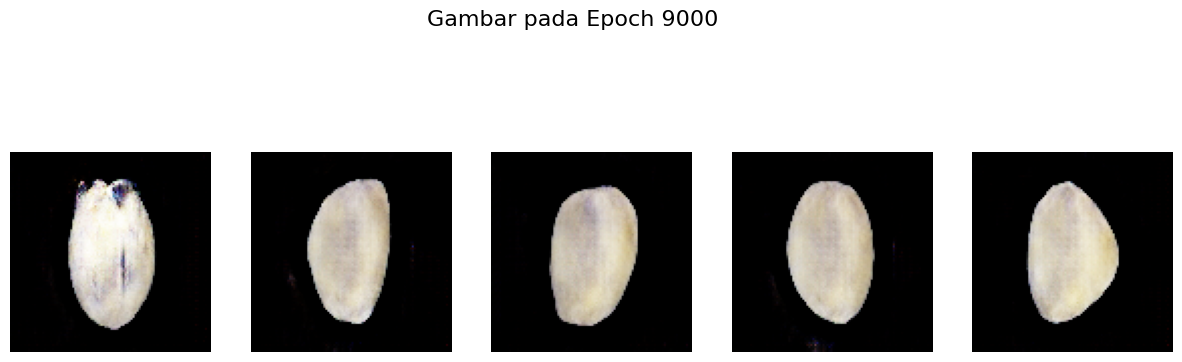

--- Menghitung FID pada epoch 9000... ---
--- FID pada epoch 9000: 790.39 ---
Epoch 9001/15000, Gen Loss: 13.3436, Disc Loss: 0.0167, Time: 0.45 sec
Epoch 9002/15000, Gen Loss: 13.5104, Disc Loss: 0.0135, Time: 0.42 sec
Epoch 9003/15000, Gen Loss: 13.6290, Disc Loss: 0.0092, Time: 0.42 sec
Epoch 9004/15000, Gen Loss: 13.1606, Disc Loss: 0.0062, Time: 0.43 sec
Epoch 9005/15000, Gen Loss: 12.3912, Disc Loss: 0.0057, Time: 0.42 sec
Epoch 9006/15000, Gen Loss: 11.9636, Disc Loss: 0.0043, Time: 0.43 sec
Epoch 9007/15000, Gen Loss: 12.2999, Disc Loss: 0.0198, Time: 0.42 sec
Epoch 9008/15000, Gen Loss: 13.7256, Disc Loss: 0.0047, Time: 0.45 sec
Epoch 9009/15000, Gen Loss: 12.8272, Disc Loss: 0.0040, Time: 0.42 sec
Epoch 9010/15000, Gen Loss: 12.5623, Disc Loss: 0.0049, Time: 0.42 sec
Epoch 9011/15000, Gen Loss: 12.7131, Disc Loss: 0.0263, Time: 0.43 sec
Epoch 9012/15000, Gen Loss: 13.4469, Disc Loss: 0.0100, Time: 0.42 sec
Epoch 9013/15000, Gen Loss: 13.6701, Disc Loss: 0.0235, Time: 0.43 sec

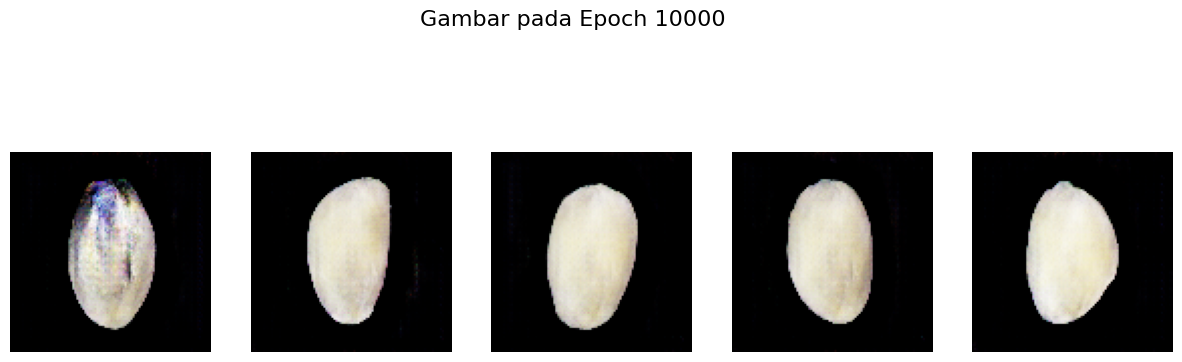

--- Menghitung FID pada epoch 10000... ---
--- FID pada epoch 10000: 791.48 ---
Epoch 10001/15000, Gen Loss: 13.4805, Disc Loss: 0.0106, Time: 0.47 sec
Epoch 10002/15000, Gen Loss: 13.2697, Disc Loss: 0.0068, Time: 0.42 sec
Epoch 10003/15000, Gen Loss: 13.5020, Disc Loss: 0.0157, Time: 0.43 sec
Epoch 10004/15000, Gen Loss: 13.9814, Disc Loss: 0.0059, Time: 0.42 sec
Epoch 10005/15000, Gen Loss: 13.5802, Disc Loss: 0.0109, Time: 0.43 sec
Epoch 10006/15000, Gen Loss: 13.3918, Disc Loss: 0.0071, Time: 0.42 sec
Epoch 10007/15000, Gen Loss: 14.1521, Disc Loss: 0.0122, Time: 0.42 sec
Epoch 10008/15000, Gen Loss: 13.4707, Disc Loss: 0.0103, Time: 0.44 sec
Epoch 10009/15000, Gen Loss: 13.9570, Disc Loss: 0.0200, Time: 0.42 sec
Epoch 10010/15000, Gen Loss: 14.1791, Disc Loss: 0.0114, Time: 0.43 sec
Epoch 10011/15000, Gen Loss: 13.4774, Disc Loss: 0.0046, Time: 0.42 sec
Epoch 10012/15000, Gen Loss: 13.9051, Disc Loss: 0.0039, Time: 0.43 sec
Epoch 10013/15000, Gen Loss: 13.6926, Disc Loss: 0.0141,

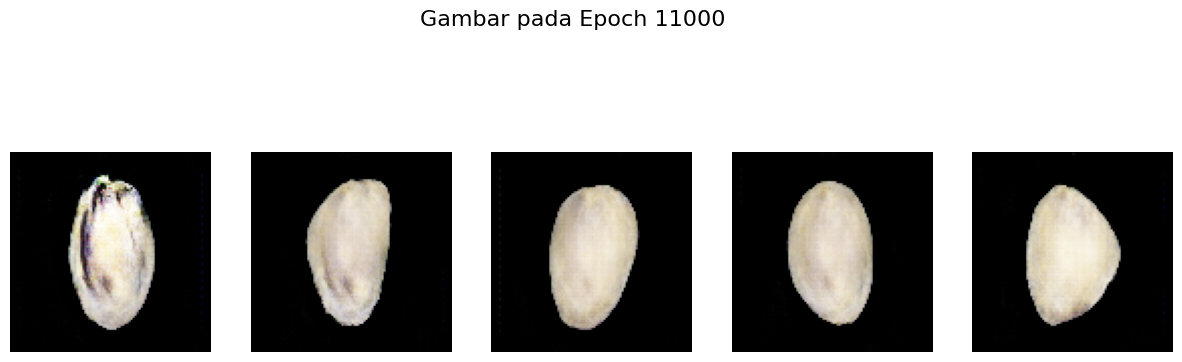

--- Menghitung FID pada epoch 11000... ---
--- FID pada epoch 11000: 682.93 ---
Epoch 11001/15000, Gen Loss: 14.2379, Disc Loss: 0.0176, Time: 0.48 sec
Epoch 11002/15000, Gen Loss: 14.3612, Disc Loss: 0.0109, Time: 0.42 sec
Epoch 11003/15000, Gen Loss: 13.7737, Disc Loss: 0.0144, Time: 0.43 sec
Epoch 11004/15000, Gen Loss: 14.1545, Disc Loss: 0.0110, Time: 0.42 sec
Epoch 11005/15000, Gen Loss: 13.3965, Disc Loss: 0.0098, Time: 0.42 sec
Epoch 11006/15000, Gen Loss: 12.9667, Disc Loss: 0.0095, Time: 0.43 sec
Epoch 11007/15000, Gen Loss: 13.4785, Disc Loss: 0.0083, Time: 0.42 sec
Epoch 11008/15000, Gen Loss: 13.6191, Disc Loss: 0.0068, Time: 0.43 sec
Epoch 11009/15000, Gen Loss: 14.4793, Disc Loss: 0.0199, Time: 0.42 sec
Epoch 11010/15000, Gen Loss: 14.3651, Disc Loss: 0.0087, Time: 0.42 sec
Epoch 11011/15000, Gen Loss: 14.2735, Disc Loss: 0.0070, Time: 0.44 sec
Epoch 11012/15000, Gen Loss: 14.2099, Disc Loss: 0.0068, Time: 0.42 sec
Epoch 11013/15000, Gen Loss: 13.9898, Disc Loss: 0.0075,

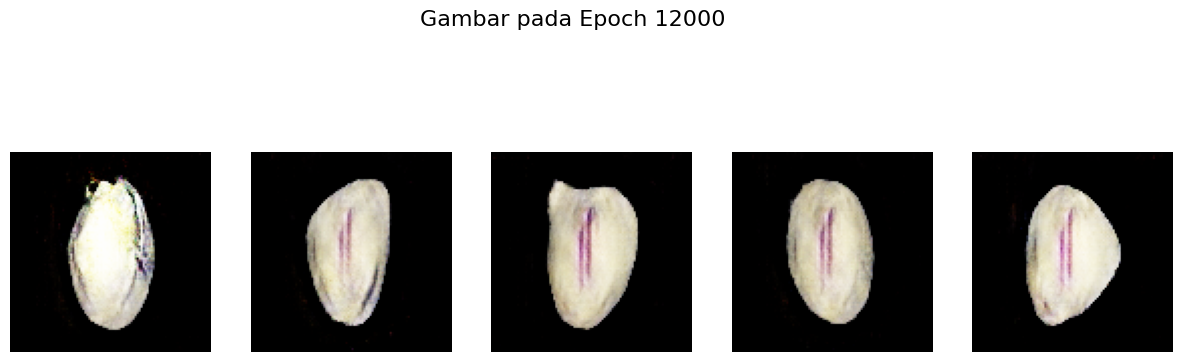

--- Menghitung FID pada epoch 12000... ---
--- FID pada epoch 12000: 806.30 ---
Epoch 12001/15000, Gen Loss: 13.6315, Disc Loss: 0.0132, Time: 0.49 sec
Epoch 12002/15000, Gen Loss: 13.5364, Disc Loss: 0.0158, Time: 0.42 sec
Epoch 12003/15000, Gen Loss: 12.9688, Disc Loss: 0.0062, Time: 0.42 sec
Epoch 12004/15000, Gen Loss: 14.1473, Disc Loss: 0.0224, Time: 0.43 sec
Epoch 12005/15000, Gen Loss: 14.8850, Disc Loss: 0.0133, Time: 0.42 sec
Epoch 12006/15000, Gen Loss: 13.8567, Disc Loss: 0.0068, Time: 0.44 sec
Epoch 12007/15000, Gen Loss: 13.2326, Disc Loss: 0.0067, Time: 0.42 sec
Epoch 12008/15000, Gen Loss: 13.4649, Disc Loss: 0.0095, Time: 0.44 sec
Epoch 12009/15000, Gen Loss: 13.4426, Disc Loss: 0.0101, Time: 0.42 sec
Epoch 12010/15000, Gen Loss: 14.6177, Disc Loss: 0.0180, Time: 0.42 sec
Epoch 12011/15000, Gen Loss: 14.3255, Disc Loss: 0.0105, Time: 0.43 sec
Epoch 12012/15000, Gen Loss: 15.9025, Disc Loss: 0.7497, Time: 0.42 sec
Epoch 12013/15000, Gen Loss: 17.0805, Disc Loss: 0.1195,

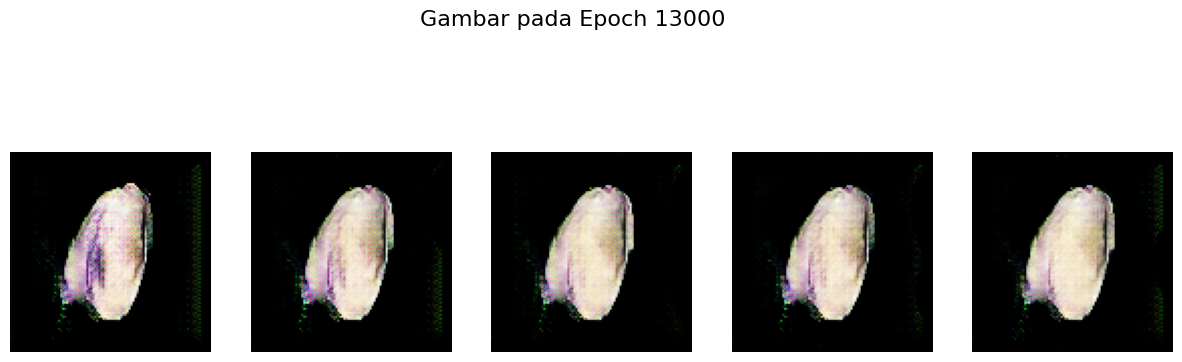

--- Menghitung FID pada epoch 13000... ---
--- FID pada epoch 13000: 1102.93 ---
Epoch 13001/15000, Gen Loss: 12.5742, Disc Loss: 0.0120, Time: 0.46 sec
Epoch 13002/15000, Gen Loss: 9.2841, Disc Loss: 0.0003, Time: 0.42 sec
Epoch 13003/15000, Gen Loss: 8.6930, Disc Loss: 0.0005, Time: 0.44 sec
Epoch 13004/15000, Gen Loss: 9.0326, Disc Loss: 0.0013, Time: 0.42 sec
Epoch 13005/15000, Gen Loss: 8.7984, Disc Loss: 0.0016, Time: 0.42 sec
Epoch 13006/15000, Gen Loss: 11.0155, Disc Loss: 0.0101, Time: 0.43 sec
Epoch 13007/15000, Gen Loss: 9.7856, Disc Loss: 0.0026, Time: 0.42 sec
Epoch 13008/15000, Gen Loss: 11.2561, Disc Loss: 0.0020, Time: 0.43 sec
Epoch 13009/15000, Gen Loss: 10.3236, Disc Loss: 0.0012, Time: 0.42 sec
Epoch 13010/15000, Gen Loss: 10.5128, Disc Loss: 0.0018, Time: 0.43 sec
Epoch 13011/15000, Gen Loss: 11.3201, Disc Loss: 0.0027, Time: 0.42 sec
Epoch 13012/15000, Gen Loss: 11.1582, Disc Loss: 0.0016, Time: 0.43 sec
Epoch 13013/15000, Gen Loss: 11.7788, Disc Loss: 0.0013, Tim

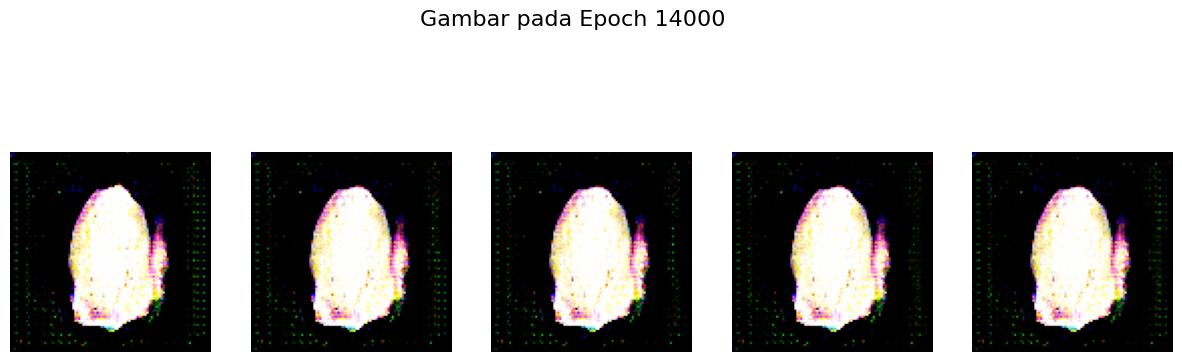

--- Menghitung FID pada epoch 14000... ---
--- FID pada epoch 14000: 1641.29 ---
Epoch 14001/15000, Gen Loss: 8.6113, Disc Loss: 0.0005, Time: 0.45 sec
Epoch 14002/15000, Gen Loss: 8.4450, Disc Loss: 0.0017, Time: 0.43 sec
Epoch 14003/15000, Gen Loss: 10.1294, Disc Loss: 0.0153, Time: 0.42 sec
Epoch 14004/15000, Gen Loss: 9.1654, Disc Loss: 0.0003, Time: 0.43 sec
Epoch 14005/15000, Gen Loss: 9.4071, Disc Loss: 0.0002, Time: 0.42 sec
Epoch 14006/15000, Gen Loss: 9.0400, Disc Loss: 0.0004, Time: 0.45 sec
Epoch 14007/15000, Gen Loss: 9.3558, Disc Loss: 0.0008, Time: 0.42 sec
Epoch 14008/15000, Gen Loss: 8.9505, Disc Loss: 0.0011, Time: 0.42 sec
Epoch 14009/15000, Gen Loss: 8.8103, Disc Loss: 0.0015, Time: 0.43 sec
Epoch 14010/15000, Gen Loss: 9.5821, Disc Loss: 0.0012, Time: 0.42 sec
Epoch 14011/15000, Gen Loss: 8.9609, Disc Loss: 0.0012, Time: 0.43 sec
Epoch 14012/15000, Gen Loss: 9.4896, Disc Loss: 0.0009, Time: 0.42 sec
Epoch 14013/15000, Gen Loss: 8.8981, Disc Loss: 0.0007, Time: 0.42

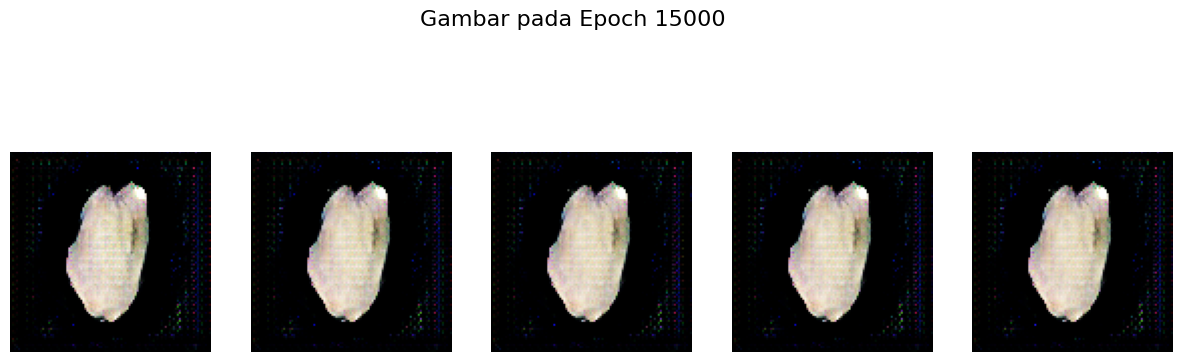

--- Menghitung FID pada epoch 15000... ---
--- FID pada epoch 15000: 4320.97 ---

Training Selesai.


In [134]:
history_modified = train_gan_and_get_history(
    real_dataset,
    EPOCHS_MODIFIED,
    generator_modified,
    discriminator_modified,
    optimizer_gen_mod,  # Gunakan optimizer khusus modifikasi
    optimizer_disc_mod, # Gunakan optimizer khusus modifikasi
    loss_fn,
    seed_for_viz
)

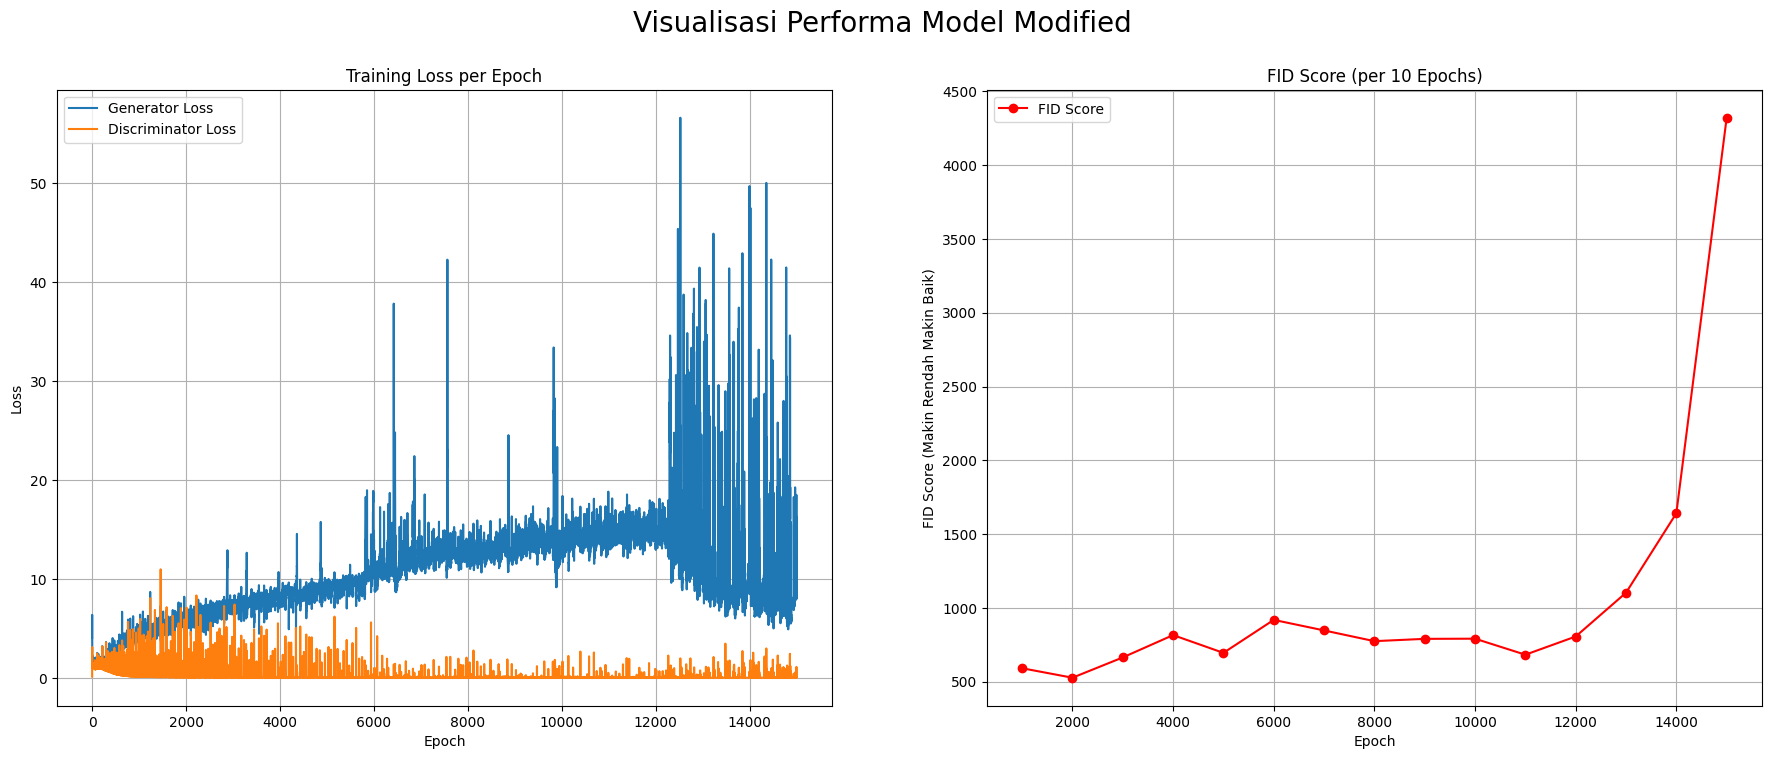

In [135]:
# Tampilkan plot histori untuk model modified
plot_history(history_modified, "Modified")

---

**1. Training Loss per Epoch**

* **Generator Loss (biru)** mengalami peningkatan bertahap hingga sekitar epoch 12000, kemudian menurun tajam. Namun, secara umum loss generator **cenderung tinggi** dan sangat fluktuatif, yang mengindikasikan **instabilitas pelatihan**.
* **Discriminator Loss (oranye)** menurun drastis seiring epoch dan stabil mendekati nol. Hal ini menunjukkan bahwa **discriminator terlalu kuat**, sehingga dapat dengan mudah membedakan gambar palsu dari gambar asli.
* Ketidakseimbangan ini menyebabkan **generator kesulitan belajar**, dan bisa mengarah pada **mode collapse** atau penurunan kualitas output.

---

**2. FID Score (per 10 Epoch)**

* FID score awalnya **stabil dan cukup rendah** (sekitar 500–900), menunjukkan kualitas gambar cukup baik di awal.
* Namun setelah sekitar **epoch 12000**, FID score **meningkat tajam hingga melebihi 4000**, menunjukkan bahwa kualitas gambar yang dihasilkan **memburuk drastis** di akhir pelatihan.
* Pola ini mengindikasikan **overfitting atau kerusakan pada proses pelatihan (training collapse)** setelah titik tertentu.

---
---

**Kesimpulan**

* Modifikasi pada model justru **memperburuk stabilitas pelatihan** dibanding baseline.
* Discriminator menjadi terlalu dominan, membuat generator tidak bisa belajar dengan baik.
* FID score menunjukkan bahwa **semakin lama model dilatih, semakin buruk performanya**, terutama setelah epoch 12000.
* Diperlukan **penyeimbangan antara generator dan discriminator**, misalnya dengan:

  * Mengatur learning rate keduanya secara berbeda,
  * Menggunakan loss alternatif (seperti WGAN-GP),
  * Menambahkan regularisasi atau strategi stabilisasi lain.


# Conclusion


### **Perbandingan Model Baseline vs Model Modified**

**Model Baseline**

* Generator loss **fluktuatif**, dengan beberapa lonjakan ekstrem, namun tidak terus memburuk.
* Discriminator loss **stabil dan rendah**, menunjukkan proses pelatihan yang relatif seimbang.
* FID score **berfluktuasi antara 690–910**, namun **tidak mengalami kenaikan drastis**.
* Kualitas gambar **tidak konsisten**, tetapi **tidak memburuk secara ekstrem** selama pelatihan.
* Pelatihan **tidak stabil sepenuhnya**, tapi **tidak mengalami training collapse**.

**Model Modified**

* Generator loss **semakin tinggi** seiring waktu, lalu tiba-tiba **turun tajam** di akhir → indikasi ketidakstabilan.
* Discriminator loss **turun drastis dan hampir nol**, menandakan **discriminator terlalu dominan**.
* FID score awalnya **stabil dan cukup rendah (sekitar 500–900)**.
* Setelah epoch 12000, FID score **naik tajam hingga lebih dari 4000** → menandakan **training collapse**.
* Kualitas gambar **semakin memburuk** di akhir pelatihan.

---

**Kesimpulan**

* **Model baseline** menunjukkan performa yang **lebih stabil secara keseluruhan**, meskipun fluktuatif.
* **Model modified** hanya unggul di awal, tetapi **gagal mempertahankan performa** dan mengalami **kerusakan pelatihan** di akhir.
* Modifikasi yang dilakukan justru membuat model **tidak seimbang dan tidak stabil**.
* Diperlukan **penyesuaian lanjutan** (seperti learning rate, teknik regularisasi, atau arsitektur alternatif) agar model bisa belajar dengan seimbang dan menghasilkan output yang konsisten.
